In [15]:
from src.loaders.data_loader import load_train_data, load_submission_data
from src.preprocessors.splitors import split_train_valid_test_for_cv, split_x_y_for_lightgbm_train
from src.preprocessors.add_columns import add_ghi, add_rolling_mean, add_rolling_mean_bulk
from src.preprocessors.feature_engineering import feature_engineering_lightgbm
from src.preprocessors.dataset_creators import create_lightgbm_dataset
from src.make_submissions.create_submission import create_submission_using_lightgbm_model

import lightgbm as lgb
import numpy as np

In [16]:
from src.loaders.experiment_loader import load_experiment

experiment_setting = load_experiment(1)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [2]:
df = load_train_data()

In [3]:
def get_lightgbm_param(experiment_setting, q):
    param = experiment_setting["params"]
    param["q"] = q
    return param

days = 5
selector = "experiment"

In [4]:
feature_engineered_df = feature_engineering_lightgbm(df)
feature_engineered_df.head(5)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,GHI,...,DNI_rolling_mean_4,DNI_rolling_mean_8,DNI_rolling_mean_12,DNI_rolling_mean_24,DNI_rolling_mean_48,GHI_rolling_mean_4,GHI_rolling_mean_8,GHI_rolling_mean_12,GHI_rolling_mean_24,GHI_rolling_mean_48
0,0,0,0,0,0,1.5,69.08,-12,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,30,0,0,1.5,69.06,-12,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1,0,0,0,1.6,71.78,-12,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1,30,0,0,1.6,71.75,-12,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,0,2,0,0,0,1.6,75.20,-12,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [6]:
history = {
    "total_error": 0,
    "submission_df": []
}

for index, (train, valid, test) in enumerate(split_train_valid_test_for_cv(feature_engineered_df, 0.5)):
    history[index] = {}
    train_1_dataset, train_2_dataset = create_lightgbm_dataset(train, days, selector)
    valid_1_dataset, valid_2_dataset = create_lightgbm_dataset(valid, days, selector)
    test_x, test_y_1, test_y_2, c = split_x_y_for_lightgbm_train(test, days)
    test_x = test_x[selector]
    submission_df = load_submission_data()
    
    for i in range(1, 10):
        q = i/10
        history[index][q] = {"bst_1": [], "bst_2": []}
        param = get_lightgbm_param(q)
        
        num_round = 5000
        bst_1 = lgb.train(param, train_1_dataset, num_round, valid_sets=[valid_1_dataset])
        bst_2 = lgb.train(param, train_2_dataset, num_round, valid_sets=[valid_2_dataset])
        
        history[index][q]["bst_1"].append(bst_1)
        history[index][q]["bst_2"].append(bst_2)
        
        y_pred_1 = bst_1.predict(test_x).reshape(-1)
        y_pred_2 = bst_2.predict(test_x).reshape(-1)

        history["total_error"] += np.sum(np.maximum(q * (test_y_1 - y_pred_1), (q - 1) * (test_y_1 - y_pred_1)))
        history["total_error"] += np.sum(np.maximum(q * (test_y_2 - y_pred_2), (q - 1) * (test_y_2 - y_pred_2)))
                
        submission_df[f"q_{q}"] = create_submission_using_lightgbm_model(selector, bst_1, bst_2, days)
    history["submission_df"].append(submission_df)

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34971
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 1.73051
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 1.71777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 1.70826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 1.69407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 1.67705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 1.66115
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[116]	valid_0's quantile: 1.35888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[117]	valid_0's quantile: 1.35867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[118]	valid_0's quantile: 1.35869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[119]	valid_0's quantile: 1.35865
[120]	valid_0's quantile: 1.35854
[121]	valid_0's quantile: 1.35809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[122]	valid_0's quantile: 1.3581
[123]	valid_0's quantile: 1.35783
[124]	valid_0's quantile: 1.35774
[125]	valid_0's quantile: 1.35749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[126]	valid_0's quantile: 1.35757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[127]	valid_0's quantile: 1.35747
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[118]	valid_0's quantile: 0.591009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[119]	valid_0's quantile: 0.583916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[120]	valid_0's quantile: 0.578121
[121]	valid_0's quantile: 0.571522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[122]	valid_0's quantile: 0.5653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's quantile: 0.559416
[124]	valid_0's quantile: 0.553285
[125]	valid_0's quantile: 0.547755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[126]	valid_0's quantile: 0.542623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[127]	valid_0's quantile: 0.537014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[128]	valid_0's quantile: 0.53623
[LightGBM] [Warnin

[257]	valid_0's quantile: 0.179809
[258]	valid_0's quantile: 0.179908
[259]	valid_0's quantile: 0.177558
[260]	valid_0's quantile: 0.176302
[261]	valid_0's quantile: 0.175082
[262]	valid_0's quantile: 0.173125
[263]	valid_0's quantile: 0.171236
[264]	valid_0's quantile: 0.169934
[265]	valid_0's quantile: 0.168326
[266]	valid_0's quantile: 0.168349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[267]	valid_0's quantile: 0.16755
[268]	valid_0's quantile: 0.166177
[269]	valid_0's quantile: 0.164987
[270]	valid_0's quantile: 0.163848
[271]	valid_0's quantile: 0.163109
[272]	valid_0's quantile: 0.162011
[273]	valid_0's quantile: 0.161036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[274]	valid_0's quantile: 0.161384
[275]	valid_0's quantile: 0.159407
[276]	valid_0's quantile: 0.157822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[277]	valid_0's quantile: 0.158034
[278]	valid_0's quantile: 0.156962
[279]	

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34971
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 3.43489
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 3.38012
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 3.31978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 3.26288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 3.20413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 3.14529
[Li

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34971
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 3.42766
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 3.3718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 3.29365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 3.2538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 3.18707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 3.13108
[7]	v

[121]	valid_0's quantile: 0.620401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[122]	valid_0's quantile: 0.615889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's quantile: 0.611398
[124]	valid_0's quantile: 0.606625
[125]	valid_0's quantile: 0.603305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[126]	valid_0's quantile: 0.598444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[127]	valid_0's quantile: 0.594366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[128]	valid_0's quantile: 0.59489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[129]	valid_0's quantile: 0.595455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[130]	valid_0's quantile: 0.592201
[131]	valid_0's quantile: 0.590473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[132]	valid_0's 

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34971
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 5.10532
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 4.97333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 4.8442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 4.72154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 4.61956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 4.49152
[Lig

[130]	valid_0's quantile: 2.52761
[131]	valid_0's quantile: 2.52679
[132]	valid_0's quantile: 2.526
[133]	valid_0's quantile: 2.5255
[134]	valid_0's quantile: 2.52547
[135]	valid_0's quantile: 2.52493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's quantile: 2.5238
[137]	valid_0's quantile: 2.52325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's quantile: 2.52319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's quantile: 2.52274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's quantile: 2.52252
[141]	valid_0's quantile: 2.52224
[142]	valid_0's quantile: 2.52233
[143]	valid_0's quantile: 2.52227
[144]	valid_0's quantile: 2.52174
[145]	valid_0's quantile: 2.52332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[146]	valid_0's quantile: 2.52332
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[89]	valid_0's quantile: 0.613756
[90]	valid_0's quantile: 0.602423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	valid_0's quantile: 0.591636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	valid_0's quantile: 0.581044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	valid_0's quantile: 0.569718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	valid_0's quantile: 0.559419
[95]	valid_0's quantile: 0.558162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	valid_0's quantile: 0.54841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	valid_0's quantile: 0.539429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	valid_0's quantile: 0.530493
[99]	valid_0's quantile: 0.521288
[LightGBM] [Warning] No fur

[220]	valid_0's quantile: 0.251187
[221]	valid_0's quantile: 0.250701
[222]	valid_0's quantile: 0.250718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[223]	valid_0's quantile: 0.250255
[224]	valid_0's quantile: 0.250305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[225]	valid_0's quantile: 0.250293
[226]	valid_0's quantile: 0.249934
[227]	valid_0's quantile: 0.249613
[228]	valid_0's quantile: 0.248594
[229]	valid_0's quantile: 0.248008
[230]	valid_0's quantile: 0.247939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[231]	valid_0's quantile: 0.247862
[232]	valid_0's quantile: 0.24785
[233]	valid_0's quantile: 0.247877
[234]	valid_0's quantile: 0.247215
[235]	valid_0's quantile: 0.246889
[236]	valid_0's quantile: 0.2465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[237]	valid_0's quantile: 0.246455
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[509]	valid_0's quantile: 0.155829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[510]	valid_0's quantile: 0.155732
[511]	valid_0's quantile: 0.15567
[512]	valid_0's quantile: 0.155447
[513]	valid_0's quantile: 0.155372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[514]	valid_0's quantile: 0.15532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[515]	valid_0's quantile: 0.155226
[516]	valid_0's quantile: 0.155227
[517]	valid_0's quantile: 0.154031
[518]	valid_0's quantile: 0.154015
[519]	valid_0's quantile: 0.154048
[520]	valid_0's quantile: 0.154008
[521]	valid_0's quantile: 0.152027
[522]	valid_0's quantile: 0.150204
[523]	valid_0's quantile: 0.150186
[524]	valid_0's quantile: 0.150137
[525]	valid_0's quantile: 0.150024
[526]	valid_0's quantile: 0.150067
[527]	valid_0's quantile: 0.150056
[528]	valid_0's quantile: 0.150044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34971
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 6.73797
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 6.49899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 6.27192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 6.05846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 5.85248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 5.67647
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's quantile: 2.64006
[135]	valid_0's quantile: 2.63966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's quantile: 2.6399
[137]	valid_0's quantile: 2.63923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's quantile: 2.64223
Early stopping, best iteration is:
[128]	valid_0's quantile: 2.63826
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34971
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 6.728
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2

[121]	valid_0's quantile: 0.667046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[122]	valid_0's quantile: 0.665231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's quantile: 0.664676
[124]	valid_0's quantile: 0.663324
[125]	valid_0's quantile: 0.662095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[126]	valid_0's quantile: 0.66188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[127]	valid_0's quantile: 0.660482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[128]	valid_0's quantile: 0.66115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[129]	valid_0's quantile: 0.66118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[130]	valid_0's quantile: 0.659474
[131]	valid_0's quantile: 0.658002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[132]	valid_0's qu

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34971
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 8.32996
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 7.95272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 7.59677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 7.28866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 6.9792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 6.70384
[Lig

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[59]	valid_0's quantile: 0.764345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's quantile: 0.739685
[61]	valid_0's quantile: 0.715779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's quantile: 0.693522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's quantile: 0.67262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's quantile: 0.652933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's quantile: 0.634006
[66]	valid_0's quantile: 0.616003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[67]	valid_0's quantile: 0.612184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	valid_0's quantile: 0.595565
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[194]	valid_0's quantile: 0.23071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[195]	valid_0's quantile: 0.230564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[196]	valid_0's quantile: 0.230368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[197]	valid_0's quantile: 0.229172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[198]	valid_0's quantile: 0.228747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[199]	valid_0's quantile: 0.228611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's quantile: 0.22824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[201]	valid_0's quantile: 0.228078
[202]	valid_0's quantile: 0.227804
[203]	valid_0's quantile: 0.22722
[204]	valid_0's quantile: 0.226545
[LightGBM] [Warnin

[328]	valid_0's quantile: 0.186708
[329]	valid_0's quantile: 0.186564
[330]	valid_0's quantile: 0.186511
[331]	valid_0's quantile: 0.186354
[332]	valid_0's quantile: 0.185869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[333]	valid_0's quantile: 0.185769
[334]	valid_0's quantile: 0.185598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[335]	valid_0's quantile: 0.185511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[336]	valid_0's quantile: 0.185096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[337]	valid_0's quantile: 0.184937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[338]	valid_0's quantile: 0.18478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[339]	valid_0's quantile: 0.184385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[340]	valid_0's quantile: 0.18398
[341]	valid_0's quanti

[464]	valid_0's quantile: 0.163374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[465]	valid_0's quantile: 0.163362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[466]	valid_0's quantile: 0.163255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[467]	valid_0's quantile: 0.163162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[468]	valid_0's quantile: 0.163043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[469]	valid_0's quantile: 0.162909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[470]	valid_0's quantile: 0.162883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[471]	valid_0's quantile: 0.162851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[472]	valid_0's quantile: 0.162757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	vali

[605]	valid_0's quantile: 0.153831
[606]	valid_0's quantile: 0.153619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	valid_0's quantile: 0.153497
[608]	valid_0's quantile: 0.153429
[609]	valid_0's quantile: 0.153373
[610]	valid_0's quantile: 0.153263
[611]	valid_0's quantile: 0.15306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[612]	valid_0's quantile: 0.153037
[613]	valid_0's quantile: 0.153018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[614]	valid_0's quantile: 0.152901
[615]	valid_0's quantile: 0.152732
[616]	valid_0's quantile: 0.152712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[617]	valid_0's quantile: 0.152703
[618]	valid_0's quantile: 0.152629
[619]	valid_0's quantile: 0.152612
[620]	valid_0's quantile: 0.152566
[621]	valid_0's quantile: 0.15247
[622]	valid_0's quantile: 0.152425
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[738]	valid_0's quantile: 0.145738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[739]	valid_0's quantile: 0.145707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[740]	valid_0's quantile: 0.14563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[741]	valid_0's quantile: 0.145564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[742]	valid_0's quantile: 0.145575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[743]	valid_0's quantile: 0.145592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[744]	valid_0's quantile: 0.145525
[745]	valid_0's quantile: 0.145516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[746]	valid_0's quantile: 0.145448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[747]	valid_0's quantile: 0.145418
[748]	valid_0's quantile: 0.145398
[LightGBM] [Warn

[872]	valid_0's quantile: 0.139327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[873]	valid_0's quantile: 0.1393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[874]	valid_0's quantile: 0.139286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[875]	valid_0's quantile: 0.139199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[876]	valid_0's quantile: 0.139112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[877]	valid_0's quantile: 0.138961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[878]	valid_0's quantile: 0.138951
[879]	valid_0's quantile: 0.138912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[880]	valid_0's quantile: 0.138884
[881]	valid_0's quantile: 0.138874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[882]	valid_0's quantile: 0.138795
[LightGBM] [Warni

[1008]	valid_0's quantile: 0.134383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1009]	valid_0's quantile: 0.134373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1010]	valid_0's quantile: 0.134345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1011]	valid_0's quantile: 0.134309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1012]	valid_0's quantile: 0.134282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1013]	valid_0's quantile: 0.134271
[1014]	valid_0's quantile: 0.134246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1015]	valid_0's quantile: 0.134131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1016]	valid_0's quantile: 0.134106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1017]	valid_0's quantile: 0.134083
[LightGBM] [Warning] No further splits w

[1141]	valid_0's quantile: 0.131579
[1142]	valid_0's quantile: 0.131573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1143]	valid_0's quantile: 0.131533
[1144]	valid_0's quantile: 0.131515
[1145]	valid_0's quantile: 0.131472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1146]	valid_0's quantile: 0.131375
[1147]	valid_0's quantile: 0.131293
[1148]	valid_0's quantile: 0.131268
[1149]	valid_0's quantile: 0.131265
[1150]	valid_0's quantile: 0.131188
[1151]	valid_0's quantile: 0.131186
[1152]	valid_0's quantile: 0.131177
[1153]	valid_0's quantile: 0.131119
[1154]	valid_0's quantile: 0.13109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1155]	valid_0's quantile: 0.131086
[1156]	valid_0's quantile: 0.131066
[1157]	valid_0's quantile: 0.131021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1158]	valid_0's quantile: 0.131019
[1159]	valid_0's quantile: 0.131
[1160]	valid_0's qua

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1281]	valid_0's quantile: 0.128791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1282]	valid_0's quantile: 0.128725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1283]	valid_0's quantile: 0.128708
[1284]	valid_0's quantile: 0.128693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1285]	valid_0's quantile: 0.128686
[1286]	valid_0's quantile: 0.128681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1287]	valid_0's quantile: 0.128625
[1288]	valid_0's quantile: 0.128537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1289]	valid_0's quantile: 0.128526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1290]	valid_0's quantile: 0.128537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1291]	valid_0's quantile: 0.128533
[Lig

[1414]	valid_0's quantile: 0.126547
[1415]	valid_0's quantile: 0.126511
[1416]	valid_0's quantile: 0.126514
[1417]	valid_0's quantile: 0.126457
[1418]	valid_0's quantile: 0.126403
[1419]	valid_0's quantile: 0.126395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1420]	valid_0's quantile: 0.126394
[1421]	valid_0's quantile: 0.126397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1422]	valid_0's quantile: 0.126392
[1423]	valid_0's quantile: 0.126396
[1424]	valid_0's quantile: 0.126395
[1425]	valid_0's quantile: 0.126353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1426]	valid_0's quantile: 0.126336
[1427]	valid_0's quantile: 0.126298
[1428]	valid_0's quantile: 0.126294
[1429]	valid_0's quantile: 0.126208
[1430]	valid_0's quantile: 0.126164
[1431]	valid_0's quantile: 0.126114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1432]	valid_0's quantile: 0.126117
[1433]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1545]	valid_0's quantile: 0.124482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1546]	valid_0's quantile: 0.124482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1547]	valid_0's quantile: 0.124478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1548]	valid_0's quantile: 0.124472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1549]	valid_0's quantile: 0.124449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1550]	valid_0's quantile: 0.124438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1551]	valid_0's quantile: 0.124441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1552]	valid_0's quantile: 0.124423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1553]	valid_0's quantile: 0.12442
[L

[1683]	valid_0's quantile: 0.122077
[1684]	valid_0's quantile: 0.122057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1685]	valid_0's quantile: 0.122027
[1686]	valid_0's quantile: 0.121998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1687]	valid_0's quantile: 0.121996
[1688]	valid_0's quantile: 0.12198
[1689]	valid_0's quantile: 0.121976
[1690]	valid_0's quantile: 0.121918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1691]	valid_0's quantile: 0.12192
[1692]	valid_0's quantile: 0.121895
[1693]	valid_0's quantile: 0.121887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1694]	valid_0's quantile: 0.121886
[1695]	valid_0's quantile: 0.121864
[1696]	valid_0's quantile: 0.121862
[1697]	valid_0's quantile: 0.121847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1698]	valid_0's quantile: 0.121822
[LightGBM] [Warning] No further splits with positiv

[1826]	valid_0's quantile: 0.119476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1827]	valid_0's quantile: 0.119473
[1828]	valid_0's quantile: 0.119455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1829]	valid_0's quantile: 0.119395
[1830]	valid_0's quantile: 0.119393
[1831]	valid_0's quantile: 0.119341
[1832]	valid_0's quantile: 0.119337
[1833]	valid_0's quantile: 0.119318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1834]	valid_0's quantile: 0.11929
[1835]	valid_0's quantile: 0.119234
[1836]	valid_0's quantile: 0.119227
[1837]	valid_0's quantile: 0.119223
[1838]	valid_0's quantile: 0.119222
[1839]	valid_0's quantile: 0.119176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1840]	valid_0's quantile: 0.119175
[1841]	valid_0's quantile: 0.119148
[1842]	valid_0's quantile: 0.119141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1843]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1962]	valid_0's quantile: 0.118111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1963]	valid_0's quantile: 0.118036
[1964]	valid_0's quantile: 0.118005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1965]	valid_0's quantile: 0.11794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1966]	valid_0's quantile: 0.117938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1967]	valid_0's quantile: 0.117941
[1968]	valid_0's quantile: 0.117938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1969]	valid_0's quantile: 0.117895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1970]	valid_0's quantile: 0.117899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1971]	valid_0's quantile: 0.1179
[LightGBM] [Warning] No further splits with

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34971
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Info] Start training from score 9.289532
[1]	valid_0's quantile: 9.656
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 9.17492
[3]	valid_0's quantile: 8.73237
[4]	valid_0's quantile: 8.3181
[5]	valid_0's quantile: 7.9327
[6]	valid_0's quantile: 7.57752
[7]	valid_0's quantile: 7.24866
[8]	valid_0's quantile: 6.93893
[9]	valid_0's quantile: 6.65655
[10]	valid_0's quantile: 6.3918
[11]	valid_0's quantile: 6.13981
[12]	valid_0's quantile: 5.90796
[13]	valid_0's quantile: 5.69678
[14]	valid_0's quantile: 5.49705
[15]	valid_0's quantile: 5.30529
[16]	valid_0's quantile: 5.12974
[17]	valid_0's quantile: 4.96674
[18]	valid_0's quantile: 4.80791
[19]	valid_0

[127]	valid_0's quantile: 2.26355
[128]	valid_0's quantile: 2.26312
[129]	valid_0's quantile: 2.26229
[130]	valid_0's quantile: 2.25913
[131]	valid_0's quantile: 2.26202
[132]	valid_0's quantile: 2.26094
[133]	valid_0's quantile: 2.25836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's quantile: 2.25621
[135]	valid_0's quantile: 2.25568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's quantile: 2.25527
[137]	valid_0's quantile: 2.2541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's quantile: 2.25354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's quantile: 2.25314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's quantile: 2.25192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's quantile: 2.2509
[142]	valid_0's quantile: 2.25049
[LightGB

[41]	valid_0's quantile: 1.1337
[42]	valid_0's quantile: 1.08233
[43]	valid_0's quantile: 1.03411
[44]	valid_0's quantile: 0.988562
[45]	valid_0's quantile: 0.946069
[46]	valid_0's quantile: 0.905801
[47]	valid_0's quantile: 0.868519
[48]	valid_0's quantile: 0.833579
[49]	valid_0's quantile: 0.80466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's quantile: 0.773319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[51]	valid_0's quantile: 0.74983
[52]	valid_0's quantile: 0.721406
[53]	valid_0's quantile: 0.699057
[54]	valid_0's quantile: 0.67633
[55]	valid_0's quantile: 0.653272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[56]	valid_0's quantile: 0.630829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[57]	valid_0's quantile: 0.610041
[58]	valid_0's quantile: 0.59077
[59]	valid_0's quantile: 0.573337
[60]	valid_0's quantile: 0.556282
[LightGBM] [Warning] No furt

[183]	valid_0's quantile: 0.260143
[184]	valid_0's quantile: 0.260028
[185]	valid_0's quantile: 0.25979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[186]	valid_0's quantile: 0.259263
[187]	valid_0's quantile: 0.258881
[188]	valid_0's quantile: 0.25845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[189]	valid_0's quantile: 0.258225
[190]	valid_0's quantile: 0.25806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[191]	valid_0's quantile: 0.257938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[192]	valid_0's quantile: 0.25775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[193]	valid_0's quantile: 0.257384
[194]	valid_0's quantile: 0.257115
[195]	valid_0's quantile: 0.256204
[196]	valid_0's quantile: 0.256028
[197]	valid_0's quantile: 0.255228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[198]	valid_0's quantile: 0.2

[317]	valid_0's quantile: 0.228616
[318]	valid_0's quantile: 0.228422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[319]	valid_0's quantile: 0.228331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[320]	valid_0's quantile: 0.228271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[321]	valid_0's quantile: 0.22775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[322]	valid_0's quantile: 0.22758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[323]	valid_0's quantile: 0.227213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[324]	valid_0's quantile: 0.227089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[325]	valid_0's quantile: 0.226945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[326]	valid_0's quantile: 0.226876
[327]	valid_0's quantile: 0.226671
[LightGBM] [Warni

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[440]	valid_0's quantile: 0.210868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[441]	valid_0's quantile: 0.210655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[442]	valid_0's quantile: 0.210455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[443]	valid_0's quantile: 0.210344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[444]	valid_0's quantile: 0.21032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[445]	valid_0's quantile: 0.210279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[446]	valid_0's quantile: 0.210152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[447]	valid_0's quantile: 0.210074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[448]	valid_0's quantile: 0.210008
[LightGBM] 

[561]	valid_0's quantile: 0.20091
[562]	valid_0's quantile: 0.20077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[563]	valid_0's quantile: 0.200816
[564]	valid_0's quantile: 0.200539
[565]	valid_0's quantile: 0.20052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[566]	valid_0's quantile: 0.200499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[567]	valid_0's quantile: 0.200433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[568]	valid_0's quantile: 0.20048
[569]	valid_0's quantile: 0.200487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[570]	valid_0's quantile: 0.200474
[571]	valid_0's quantile: 0.200284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[572]	valid_0's quantile: 0.200251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[573]	valid_0's quantile: 0.200216
[LightGBM] [Warning] No 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[696]	valid_0's quantile: 0.191646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[697]	valid_0's quantile: 0.191609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[698]	valid_0's quantile: 0.191578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[699]	valid_0's quantile: 0.191581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[700]	valid_0's quantile: 0.191585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[701]	valid_0's quantile: 0.191515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[702]	valid_0's quantile: 0.19143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[703]	valid_0's quantile: 0.191417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[704]	valid_0's quantile: 0.191248
[LightGBM] 

[824]	valid_0's quantile: 0.184928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[825]	valid_0's quantile: 0.184902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[826]	valid_0's quantile: 0.184852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[827]	valid_0's quantile: 0.184826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[828]	valid_0's quantile: 0.184808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[829]	valid_0's quantile: 0.184762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[830]	valid_0's quantile: 0.184769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[831]	valid_0's quantile: 0.184651
[832]	valid_0's quantile: 0.184482
[833]	valid_0's quantile: 0.18452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[834]	valid_0's quantile: 0.184416
[LightGBM] [Warn

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34971
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Info] Start training from score 23.458515
[1]	valid_0's quantile: 9.81655
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 9.31124
[3]	valid_0's quantile: 8.84401
[4]	valid_0's quantile: 8.41335
[5]	valid_0's quantile: 8.00157
[6]	valid_0's quantile: 7.61846
[7]	valid_0's quantile: 7.25588
[8]	valid_0's quantile: 6.92581
[9]	valid_0's quantile: 6.61027
[10]	valid_0's quantile: 6.31991
[11]	valid_0's quantile: 6.05337
[12]	valid_0's quantile: 5.80552
[13]	valid_0's quantile: 5.5688
[14]	valid_0's quantile: 5.349
[15]	valid_0's quantile: 5.14318
[16]	valid_0's quantile: 4.95526
[17]	valid_0's quantile: 4.77626
[18]	valid_0's quantile: 4.6081
[19]	valid

[137]	valid_0's quantile: 1.81975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's quantile: 1.8192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's quantile: 1.81835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's quantile: 1.81758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's quantile: 1.81721
[142]	valid_0's quantile: 1.81543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's quantile: 1.81521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[144]	valid_0's quantile: 1.81382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[145]	valid_0's quantile: 1.81362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[146]	valid_0's quantile: 1.81647
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[103]	valid_0's quantile: 0.272599
[104]	valid_0's quantile: 0.271293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	valid_0's quantile: 0.270399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[106]	valid_0's quantile: 0.269186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[107]	valid_0's quantile: 0.268015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[108]	valid_0's quantile: 0.266892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[109]	valid_0's quantile: 0.266181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[110]	valid_0's quantile: 0.265203
[111]	valid_0's quantile: 0.264307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[112]	valid_0's quantile: 0.263801
[LightGBM] [Warning] No further splits with positi

[243]	valid_0's quantile: 0.211361
[244]	valid_0's quantile: 0.210991
[245]	valid_0's quantile: 0.210821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[246]	valid_0's quantile: 0.210593
[247]	valid_0's quantile: 0.210494
[248]	valid_0's quantile: 0.21034
[249]	valid_0's quantile: 0.210183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[250]	valid_0's quantile: 0.210146
[251]	valid_0's quantile: 0.209773
[252]	valid_0's quantile: 0.20952
[253]	valid_0's quantile: 0.209367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[254]	valid_0's quantile: 0.209178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[255]	valid_0's quantile: 0.208668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[256]	valid_0's quantile: 0.208535
[257]	valid_0's quantile: 0.208481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[258]	valid_0's quantile: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[377]	valid_0's quantile: 0.194342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[378]	valid_0's quantile: 0.194239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[379]	valid_0's quantile: 0.194182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[380]	valid_0's quantile: 0.194114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[381]	valid_0's quantile: 0.194056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[382]	valid_0's quantile: 0.193979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[383]	valid_0's quantile: 0.193803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[384]	valid_0's quantile: 0.193744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[385]	valid_0's quantile: 0.193613
[LightGBM]

[510]	valid_0's quantile: 0.183433
[511]	valid_0's quantile: 0.1834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[512]	valid_0's quantile: 0.183246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[513]	valid_0's quantile: 0.183366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[514]	valid_0's quantile: 0.183422
[515]	valid_0's quantile: 0.18341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[516]	valid_0's quantile: 0.183384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[517]	valid_0's quantile: 0.183393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[518]	valid_0's quantile: 0.183354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[519]	valid_0's quantile: 0.183242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[520]	valid_0's quantile: 0.183232
[LightGBM] [Warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[643]	valid_0's quantile: 0.175921
[644]	valid_0's quantile: 0.175797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[645]	valid_0's quantile: 0.175777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[646]	valid_0's quantile: 0.175732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[647]	valid_0's quantile: 0.175727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[648]	valid_0's quantile: 0.175772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[649]	valid_0's quantile: 0.175723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[650]	valid_0's quantile: 0.175686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[651]	valid_0's quantile: 0.175635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[652]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[777]	valid_0's quantile: 0.166999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[778]	valid_0's quantile: 0.166933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[779]	valid_0's quantile: 0.166834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[780]	valid_0's quantile: 0.166839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[781]	valid_0's quantile: 0.166832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[782]	valid_0's quantile: 0.166795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[783]	valid_0's quantile: 0.166707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[784]	valid_0's quantile: 0.166522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[785]	valid_0's quantile: 0.166433
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[912]	valid_0's quantile: 0.161995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[913]	valid_0's quantile: 0.161936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[914]	valid_0's quantile: 0.161912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[915]	valid_0's quantile: 0.161891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[916]	valid_0's quantile: 0.161889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[917]	valid_0's quantile: 0.16189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[918]	valid_0's quantile: 0.161869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[919]	valid_0's quantile: 0.161785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[920]	valid_0's quantile: 0.161774
[LightGBM] 

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34971
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Info] Start training from score 41.104828
[1]	valid_0's quantile: 8.47772
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 8.04375
[3]	valid_0's quantile: 7.65585
[4]	valid_0's quantile: 7.2815
[5]	valid_0's quantile: 6.93035
[6]	valid_0's quantile: 6.59683
[7]	valid_0's quantile: 6.28434
[8]	valid_0's quantile: 5.98947
[9]	valid_0's quantile: 5.71338
[10]	valid_0's quantile: 5.44248
[11]	valid_0's quantile: 5.19442
[12]	valid_0's quantile: 4.97502
[13]	valid_0's quantile: 4.76839
[14]	valid_0's quantile: 4.56635
[15]	valid_0's quantile: 4.37342
[16]	valid_0's quantile: 4.19553
[17]	valid_0's quantile: 4.03381
[18]	valid_0's quantile: 3.88305
[19]	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[145]	valid_0's quantile: 1.30386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[146]	valid_0's quantile: 1.3035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[147]	valid_0's quantile: 1.30323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[148]	valid_0's quantile: 1.30297
[149]	valid_0's quantile: 1.30268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	valid_0's quantile: 1.30243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	valid_0's quantile: 1.30205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's quantile: 1.30174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	valid_0's quantile: 1.30151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	valid_0's quan

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34971
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Info] Start training from score 40.538807
[1]	valid_0's quantile: 8.43018
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 7.94904
[3]	valid_0's quantile: 7.50328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 7.1389
[5]	valid_0's quantile: 6.73711
[6]	valid_0's quantile: 6.36892
[7]	valid_0's quantile: 6.02031
[8]	valid_0's quantile: 5.69228
[9]	valid_0's quantile: 5.38308
[10]	valid_0's quantile: 5.08847
[11]	valid_0's quantile: 4.81728
[12]	valid_0's quantile: 4.56195
[13]	valid_0's quantile: 4.31591
[14]	valid_0's quantile: 4.08449
[15]	valid_0's quantile: 3.86575
[16]	valid_0's quantile: 3.6575

[141]	valid_0's quantile: 0.243268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's quantile: 0.241615
[143]	valid_0's quantile: 0.241178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[144]	valid_0's quantile: 0.240688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[145]	valid_0's quantile: 0.24025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[146]	valid_0's quantile: 0.239622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[147]	valid_0's quantile: 0.239181
[148]	valid_0's quantile: 0.238742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[149]	valid_0's quantile: 0.237385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	valid_0's quantile: 0.236054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	valid_0's quantile: 0.234821
[152]	valid_0's 

[285]	valid_0's quantile: 0.189782
[286]	valid_0's quantile: 0.189619
[287]	valid_0's quantile: 0.18944
[288]	valid_0's quantile: 0.188914
[289]	valid_0's quantile: 0.188751
[290]	valid_0's quantile: 0.188721
[291]	valid_0's quantile: 0.188581
[292]	valid_0's quantile: 0.187976
[293]	valid_0's quantile: 0.187499
[294]	valid_0's quantile: 0.187282
[295]	valid_0's quantile: 0.187203
[296]	valid_0's quantile: 0.186717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[297]	valid_0's quantile: 0.186616
[298]	valid_0's quantile: 0.186588
[299]	valid_0's quantile: 0.186392
[300]	valid_0's quantile: 0.186385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[301]	valid_0's quantile: 0.186201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[302]	valid_0's quantile: 0.186035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[303]	valid_0's quantile: 0.186082
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[421]	valid_0's quantile: 0.166611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[422]	valid_0's quantile: 0.166581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[423]	valid_0's quantile: 0.166516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[424]	valid_0's quantile: 0.1665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[425]	valid_0's quantile: 0.166619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[426]	valid_0's quantile: 0.166575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[427]	valid_0's quantile: 0.166344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[428]	valid_0's quantile: 0.166295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[429]	valid_0's quantile: 0.166279
[LightGBM] [

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[556]	valid_0's quantile: 0.154388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[557]	valid_0's quantile: 0.154284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[558]	valid_0's quantile: 0.154198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[559]	valid_0's quantile: 0.154188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[560]	valid_0's quantile: 0.154128
[561]	valid_0's quantile: 0.154113
[562]	valid_0's quantile: 0.154104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[563]	valid_0's quantile: 0.154085
[564]	valid_0's quantile: 0.154075
[565]	valid_0's quantile: 0.154072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[566]	valid_0's quantile: 0.154038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[567]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[697]	valid_0's quantile: 0.14845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[698]	valid_0's quantile: 0.148453
[699]	valid_0's quantile: 0.148419
[700]	valid_0's quantile: 0.148413
[701]	valid_0's quantile: 0.148408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[702]	valid_0's quantile: 0.148387
[703]	valid_0's quantile: 0.14837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[704]	valid_0's quantile: 0.148335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[705]	valid_0's quantile: 0.148267
[706]	valid_0's quantile: 0.148259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[707]	valid_0's quantile: 0.148254
[708]	valid_0's quantile: 0.148206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[709]	valid_0's quantile: 0.148127
[710]	valid_0's quanti

[840]	valid_0's quantile: 0.144708
[841]	valid_0's quantile: 0.144687
[842]	valid_0's quantile: 0.144671
[843]	valid_0's quantile: 0.144669
[844]	valid_0's quantile: 0.144659
[845]	valid_0's quantile: 0.144661
[846]	valid_0's quantile: 0.144652
[847]	valid_0's quantile: 0.144653
[848]	valid_0's quantile: 0.144645
[849]	valid_0's quantile: 0.144614
[850]	valid_0's quantile: 0.144614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[851]	valid_0's quantile: 0.144616
[852]	valid_0's quantile: 0.144594
[853]	valid_0's quantile: 0.144558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[854]	valid_0's quantile: 0.144532
[855]	valid_0's quantile: 0.144471
[856]	valid_0's quantile: 0.144443
[857]	valid_0's quantile: 0.14444
[858]	valid_0's quantile: 0.144433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[859]	valid_0's quantile: 0.144412
[860]	valid_0's quantile: 0.144391
[861]	valid_0's quantile: 0.144371
[Light

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[987]	valid_0's quantile: 0.141314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[988]	valid_0's quantile: 0.141299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[989]	valid_0's quantile: 0.141257
[990]	valid_0's quantile: 0.141256
[991]	valid_0's quantile: 0.141196
[992]	valid_0's quantile: 0.141192
[993]	valid_0's quantile: 0.14119
[994]	valid_0's quantile: 0.141187
[995]	valid_0's quantile: 0.141154
[996]	valid_0's quantile: 0.141151
[997]	valid_0's quantile: 0.141147
[998]	valid_0's quantile: 0.141141
[999]	valid_0's quantile: 0.141091
[1000]	valid_0's quantile: 0.141039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1001]	valid_0's quantile: 0.140997
[1002]	valid_0's quantile: 0.140987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1003]	valid_0's quantile: 0.140935
[1004]	valid_0's quantile: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1129]	valid_0's quantile: 0.138509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1130]	valid_0's quantile: 0.138548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1131]	valid_0's quantile: 0.138546
[1132]	valid_0's quantile: 0.138521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1133]	valid_0's quantile: 0.138482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1134]	valid_0's quantile: 0.138479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1135]	valid_0's quantile: 0.138382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1136]	valid_0's quantile: 0.138348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1137]	valid_0's quantile: 0.138354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[1272]	valid_0's quantile: 0.136385
[1273]	valid_0's quantile: 0.13638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1274]	valid_0's quantile: 0.136376
[1275]	valid_0's quantile: 0.136369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1276]	valid_0's quantile: 0.136314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1277]	valid_0's quantile: 0.136289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1278]	valid_0's quantile: 0.136287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1279]	valid_0's quantile: 0.13628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1280]	valid_0's quantile: 0.136277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1281]	valid_0's quantile: 0.136237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1282]	valid_0's quantile: 0.13623
[LightG

[1417]	valid_0's quantile: 0.134763
[1418]	valid_0's quantile: 0.134719
[1419]	valid_0's quantile: 0.134719
[1420]	valid_0's quantile: 0.134717
[1421]	valid_0's quantile: 0.134716
[1422]	valid_0's quantile: 0.134714
[1423]	valid_0's quantile: 0.134696
[1424]	valid_0's quantile: 0.134681
[1425]	valid_0's quantile: 0.134687
[1426]	valid_0's quantile: 0.134691
[1427]	valid_0's quantile: 0.134688
[1428]	valid_0's quantile: 0.134677
[1429]	valid_0's quantile: 0.134677
[1430]	valid_0's quantile: 0.134649
[1431]	valid_0's quantile: 0.134641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1432]	valid_0's quantile: 0.134639
[1433]	valid_0's quantile: 0.134638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1434]	valid_0's quantile: 0.134639
[1435]	valid_0's quantile: 0.134635
[1436]	valid_0's quantile: 0.13463
[1437]	valid_0's quantile: 0.134628
[1438]	valid_0's quantile: 0.134621
[1439]	valid_0's quantile: 0.134603
[LightGBM] [Warning] No

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34971
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Info] Start training from score 61.831615
[1]	valid_0's quantile: 5.55949
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 5.38985
[3]	valid_0's quantile: 5.23335
[4]	valid_0's quantile: 5.09215
[5]	valid_0's quantile: 4.95182
[6]	valid_0's quantile: 4.81454
[7]	valid_0's quantile: 4.68579
[8]	valid_0's quantile: 4.52435
[9]	valid_0's quantile: 4.40912
[10]	valid_0's quantile: 4.28025
[11]	valid_0's quantile: 4.12267
[12]	valid_0's quantile: 3.97994
[13]	valid_0's quantile: 3.85561
[14]	valid_0's quantile: 3.72606
[15]	valid_0's quantile: 3.59924
[16]	valid_0's quantile: 3.48196
[17]	valid_0's quantile: 3.37338
[18]	valid_0's quantile: 3.25966
[19]	v

[142]	valid_0's quantile: 0.762232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's quantile: 0.761686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[144]	valid_0's quantile: 0.76103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[145]	valid_0's quantile: 0.76074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[146]	valid_0's quantile: 0.760331
[147]	valid_0's quantile: 0.759571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[148]	valid_0's quantile: 0.75887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[149]	valid_0's quantile: 0.758568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	valid_0's quantile: 0.75794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	valid_0's quantile: 0.757723
[LightGBM] [Warning] No further splits with positive g

[279]	valid_0's quantile: 0.729368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[280]	valid_0's quantile: 0.729125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[281]	valid_0's quantile: 0.729003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[282]	valid_0's quantile: 0.728976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[283]	valid_0's quantile: 0.728669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[284]	valid_0's quantile: 0.728684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[285]	valid_0's quantile: 0.728374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[286]	valid_0's quantile: 0.728295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[287]	valid_0's quantile: 0.728235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[288]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[47]	valid_0's quantile: 1.35669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[48]	valid_0's quantile: 1.31792
[49]	valid_0's quantile: 1.28004
[50]	valid_0's quantile: 1.24331
[51]	valid_0's quantile: 1.19824
[52]	valid_0's quantile: 1.16277
[53]	valid_0's quantile: 1.12684
[54]	valid_0's quantile: 1.09814
[55]	valid_0's quantile: 1.06396
[56]	valid_0's quantile: 1.02755
[57]	valid_0's quantile: 0.994965
[58]	valid_0's quantile: 0.963397
[59]	valid_0's quantile: 0.932065
[60]	valid_0's quantile: 0.913259
[61]	valid_0's quantile: 0.885078
[62]	valid_0's quantile: 0.856443
[63]	valid_0's quantile: 0.841434
[64]	valid_0's quantile: 0.814988
[65]	valid_0's quantile: 0.788714
[66]	valid_0's quantile: 0.763979
[67]	valid_0's quantile: 0.73657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	valid_0's quantile: 0.713023
[69]	valid_0's quantile: 0.695221
[70]

[184]	valid_0's quantile: 0.149823
[185]	valid_0's quantile: 0.148551
[186]	valid_0's quantile: 0.148244
[187]	valid_0's quantile: 0.147052
[188]	valid_0's quantile: 0.146812
[189]	valid_0's quantile: 0.146039
[190]	valid_0's quantile: 0.145006
[191]	valid_0's quantile: 0.144228
[192]	valid_0's quantile: 0.144016
[193]	valid_0's quantile: 0.143757
[194]	valid_0's quantile: 0.143054
[195]	valid_0's quantile: 0.142867
[196]	valid_0's quantile: 0.14258
[197]	valid_0's quantile: 0.141636
[198]	valid_0's quantile: 0.140957
[199]	valid_0's quantile: 0.140791
[200]	valid_0's quantile: 0.140644
[201]	valid_0's quantile: 0.140378
[202]	valid_0's quantile: 0.140091
[203]	valid_0's quantile: 0.13948
[204]	valid_0's quantile: 0.138978
[205]	valid_0's quantile: 0.138825
[206]	valid_0's quantile: 0.138683
[207]	valid_0's quantile: 0.137833
[208]	valid_0's quantile: 0.137365
[209]	valid_0's quantile: 0.136858
[210]	valid_0's quantile: 0.136632
[211]	valid_0's quantile: 0.135697
[LightGBM] [Warning] N

[488]	valid_0's quantile: 0.105512
[489]	valid_0's quantile: 0.105424
[490]	valid_0's quantile: 0.10535
[491]	valid_0's quantile: 0.105282
[492]	valid_0's quantile: 0.105166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[493]	valid_0's quantile: 0.105061
[494]	valid_0's quantile: 0.104977
[495]	valid_0's quantile: 0.104974
[496]	valid_0's quantile: 0.104946
[497]	valid_0's quantile: 0.104851
[498]	valid_0's quantile: 0.104756
[499]	valid_0's quantile: 0.104707
[500]	valid_0's quantile: 0.104705
[501]	valid_0's quantile: 0.104698
[502]	valid_0's quantile: 0.104648
[503]	valid_0's quantile: 0.104598
[504]	valid_0's quantile: 0.104569
[505]	valid_0's quantile: 0.10452
[506]	valid_0's quantile: 0.10449
[507]	valid_0's quantile: 0.104377
[508]	valid_0's quantile: 0.104378
[509]	valid_0's quantile: 0.104378
[510]	valid_0's quantile: 0.104378
[511]	valid_0's quantile: 0.104375
[512]	valid_0's quantile: 0.104319
[513]	valid_0's quantile: 0.104208
[514]	valid_0's qu

[815]	valid_0's quantile: 0.0895123
[816]	valid_0's quantile: 0.0894296
[817]	valid_0's quantile: 0.0893867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[818]	valid_0's quantile: 0.0893569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[819]	valid_0's quantile: 0.089293
[820]	valid_0's quantile: 0.0892347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[821]	valid_0's quantile: 0.0892344
[822]	valid_0's quantile: 0.0891557
[823]	valid_0's quantile: 0.0889873
[824]	valid_0's quantile: 0.0889293
[825]	valid_0's quantile: 0.0889173
[826]	valid_0's quantile: 0.0889179
[827]	valid_0's quantile: 0.0888034
[828]	valid_0's quantile: 0.0887499
[829]	valid_0's quantile: 0.0884348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[830]	valid_0's quantile: 0.0880945
[831]	valid_0's quantile: 0.0880934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[832]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[978]	valid_0's quantile: 0.0837544
[979]	valid_0's quantile: 0.083716
[980]	valid_0's quantile: 0.0836921
[981]	valid_0's quantile: 0.0836718
[982]	valid_0's quantile: 0.0836219
[983]	valid_0's quantile: 0.0834727
[984]	valid_0's quantile: 0.0834464
[985]	valid_0's quantile: 0.0834456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[986]	valid_0's quantile: 0.083427
[987]	valid_0's quantile: 0.0832345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[988]	valid_0's quantile: 0.0832333
[989]	valid_0's quantile: 0.083232
[990]	valid_0's quantile: 0.0832238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[991]	valid_0's quantile: 0.0831758
[992]	valid_0's quantile: 0.0831754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[993]	valid_0's quantile: 0.0831753
[994]	valid_0's quantile: 0.0831758
[995]	valid_0's 

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34997
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 1.83126
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 1.8188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 1.80842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 1.79383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 1.77978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 1.7694
[Ligh

[122]	valid_0's quantile: 1.48861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's quantile: 1.48854
[124]	valid_0's quantile: 1.48863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	valid_0's quantile: 1.48876
Early stopping, best iteration is:
[115]	valid_0's quantile: 1.48831
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34997
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 1.82202
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 1.81167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[189]	valid_0's quantile: 0.332148
[190]	valid_0's quantile: 0.328812
[191]	valid_0's quantile: 0.325657
[192]	valid_0's quantile: 0.32246
[193]	valid_0's quantile: 0.321678
[194]	valid_0's quantile: 0.318374
[195]	valid_0's quantile: 0.315009
[196]	valid_0's quantile: 0.311824
[197]	valid_0's quantile: 0.308806
[198]	valid_0's quantile: 0.307087
[199]	valid_0's quantile: 0.304404
[200]	valid_0's quantile: 0.303688
[201]	valid_0's quantile: 0.303022
[202]	valid_0's quantile: 0.29997
[203]	valid_0's quantile: 0.297071
[204]	valid_0's quantile: 0.29507
[205]	valid_0's quantile: 0.294871
[206]	valid_0's quantile: 0.292945
[207]	valid_0's quantile: 0.289865
[208]	valid_0's quantile: 0.286951
[209]	valid_0's quantile: 0.284207
[210]	valid_0's quantile: 0.281321
[211]	valid_0's quantile: 0.278702
[212]	valid_0's quantile: 0.276217
[213]	valid_0's quantile: 0.273671
[214]	valid_0's quantile: 0.271024
[215]	valid_0's quantile: 0.268507
[216]	valid_0's quantile: 0.265752
[217]	valid_0's quantil

[499]	valid_0's quantile: 0.0695186
[500]	valid_0's quantile: 0.0694914
[501]	valid_0's quantile: 0.0692829
[502]	valid_0's quantile: 0.0691398
[503]	valid_0's quantile: 0.0689298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[504]	valid_0's quantile: 0.0688716
[505]	valid_0's quantile: 0.068681
[506]	valid_0's quantile: 0.0685036
[507]	valid_0's quantile: 0.0683283
[508]	valid_0's quantile: 0.0681
[509]	valid_0's quantile: 0.0679703
[510]	valid_0's quantile: 0.0679703
[511]	valid_0's quantile: 0.0678134
[512]	valid_0's quantile: 0.067713
[513]	valid_0's quantile: 0.0674799
[514]	valid_0's quantile: 0.0674194
[515]	valid_0's quantile: 0.0673013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[516]	valid_0's quantile: 0.0672231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[517]	valid_0's quantile: 0.0671178
[518]	valid_0's quantile: 0.0670232
[519]	valid_0's quantile: 0.0669733
[LightGBM] [Warning] No 

[815]	valid_0's quantile: 0.0483055
[816]	valid_0's quantile: 0.0482973
[817]	valid_0's quantile: 0.0482669
[818]	valid_0's quantile: 0.0481452
[819]	valid_0's quantile: 0.0480352
[820]	valid_0's quantile: 0.0480348
[821]	valid_0's quantile: 0.0480371
[822]	valid_0's quantile: 0.0480042
[823]	valid_0's quantile: 0.0478791
[824]	valid_0's quantile: 0.047871
[825]	valid_0's quantile: 0.0478158
[826]	valid_0's quantile: 0.0477801
[827]	valid_0's quantile: 0.0476968
[828]	valid_0's quantile: 0.0476821
[829]	valid_0's quantile: 0.0476262
[830]	valid_0's quantile: 0.0475933
[831]	valid_0's quantile: 0.0475726
[832]	valid_0's quantile: 0.0475472
[833]	valid_0's quantile: 0.0475425
[834]	valid_0's quantile: 0.0475393
[835]	valid_0's quantile: 0.0475068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[836]	valid_0's quantile: 0.0474754
[837]	valid_0's quantile: 0.0474479
[838]	valid_0's quantile: 0.047326
[839]	valid_0's quantile: 0.0473012
[LightGBM] [Warning] No fur

[1132]	valid_0's quantile: 0.0414302
[1133]	valid_0's quantile: 0.0414212
[1134]	valid_0's quantile: 0.0414027
[1135]	valid_0's quantile: 0.041388
[1136]	valid_0's quantile: 0.0413848
[1137]	valid_0's quantile: 0.0413672
[1138]	valid_0's quantile: 0.0413442
[1139]	valid_0's quantile: 0.041326
[1140]	valid_0's quantile: 0.0412833
[1141]	valid_0's quantile: 0.0412838
[1142]	valid_0's quantile: 0.0412826
[1143]	valid_0's quantile: 0.0412639
[1144]	valid_0's quantile: 0.0412575
[1145]	valid_0's quantile: 0.0412515
[1146]	valid_0's quantile: 0.0412455
[1147]	valid_0's quantile: 0.041216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1148]	valid_0's quantile: 0.041217
[1149]	valid_0's quantile: 0.0412124
[1150]	valid_0's quantile: 0.0411847
[1151]	valid_0's quantile: 0.0411757
[1152]	valid_0's quantile: 0.0411738
[1153]	valid_0's quantile: 0.0411596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1154]	valid_0's quantile: 0.0411413
[11

[1290]	valid_0's quantile: 0.0396503
[1291]	valid_0's quantile: 0.0396502
[1292]	valid_0's quantile: 0.0396428
[1293]	valid_0's quantile: 0.0396136
[1294]	valid_0's quantile: 0.0395924
[1295]	valid_0's quantile: 0.0395581
[1296]	valid_0's quantile: 0.0395563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1297]	valid_0's quantile: 0.0395566
[1298]	valid_0's quantile: 0.0395522
[1299]	valid_0's quantile: 0.039531
[1300]	valid_0's quantile: 0.0395255
[1301]	valid_0's quantile: 0.0395228
[1302]	valid_0's quantile: 0.0394716
[1303]	valid_0's quantile: 0.0394665
[1304]	valid_0's quantile: 0.0394592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1305]	valid_0's quantile: 0.0394612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1306]	valid_0's quantile: 0.0394612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1307]	valid_0's quantile: 0.0394613
[LightGBM] [Warning] No further spl

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34997
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 3.63308
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 3.57196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 3.50738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 3.45354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 3.40599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 3.34869
[Li

[31]	valid_0's quantile: 2.14019
[32]	valid_0's quantile: 2.10029
[33]	valid_0's quantile: 2.06141
[34]	valid_0's quantile: 2.02403
[35]	valid_0's quantile: 1.98804
[36]	valid_0's quantile: 1.97236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[37]	valid_0's quantile: 1.93521
[38]	valid_0's quantile: 1.90066
[39]	valid_0's quantile: 1.8668
[40]	valid_0's quantile: 1.83323
[41]	valid_0's quantile: 1.8004
[42]	valid_0's quantile: 1.76912
[43]	valid_0's quantile: 1.73906
[44]	valid_0's quantile: 1.70871
[45]	valid_0's quantile: 1.67857
[46]	valid_0's quantile: 1.64991
[47]	valid_0's quantile: 1.62283
[48]	valid_0's quantile: 1.59472
[49]	valid_0's quantile: 1.56428
[50]	valid_0's quantile: 1.53691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[51]	valid_0's quantile: 1.51019
[52]	valid_0's quantile: 1.48419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[53]	valid_0's quantile: 1.46218
[54]	valid_0's qua

[343]	valid_0's quantile: 0.126195
[344]	valid_0's quantile: 0.125552
[345]	valid_0's quantile: 0.125475
[346]	valid_0's quantile: 0.125352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[347]	valid_0's quantile: 0.125269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[348]	valid_0's quantile: 0.125236
[349]	valid_0's quantile: 0.12427
[350]	valid_0's quantile: 0.124093
[351]	valid_0's quantile: 0.123223
[352]	valid_0's quantile: 0.123022
[353]	valid_0's quantile: 0.122809
[354]	valid_0's quantile: 0.122621
[355]	valid_0's quantile: 0.122457
[356]	valid_0's quantile: 0.122286
[357]	valid_0's quantile: 0.12214
[358]	valid_0's quantile: 0.121982
[359]	valid_0's quantile: 0.121848
[360]	valid_0's quantile: 0.121698
[361]	valid_0's quantile: 0.121487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[362]	valid_0's quantile: 0.12139
[363]	valid_0's quantile: 0.120618
[364]	valid_0's quantile: 0.120454
[365]	va

[656]	valid_0's quantile: 0.0885631
[657]	valid_0's quantile: 0.0885278
[658]	valid_0's quantile: 0.08852
[659]	valid_0's quantile: 0.088401
[660]	valid_0's quantile: 0.0883651
[661]	valid_0's quantile: 0.0882559
[662]	valid_0's quantile: 0.0882463
[663]	valid_0's quantile: 0.0882328
[664]	valid_0's quantile: 0.0882278
[665]	valid_0's quantile: 0.088215
[666]	valid_0's quantile: 0.088171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[667]	valid_0's quantile: 0.0881767
[668]	valid_0's quantile: 0.0881679
[669]	valid_0's quantile: 0.0879704
[670]	valid_0's quantile: 0.0877835
[671]	valid_0's quantile: 0.0876092
[672]	valid_0's quantile: 0.0875952
[673]	valid_0's quantile: 0.0875227
[674]	valid_0's quantile: 0.0874013
[675]	valid_0's quantile: 0.0873619
[676]	valid_0's quantile: 0.087196
[677]	valid_0's quantile: 0.0871768
[678]	valid_0's quantile: 0.0870263
[679]	valid_0's quantile: 0.0869993
[680]	valid_0's quantile: 0.086996
[681]	valid_0's quantile: 0.0869

[966]	valid_0's quantile: 0.0772795
[967]	valid_0's quantile: 0.0772674
[968]	valid_0's quantile: 0.0772689
[969]	valid_0's quantile: 0.0772628
[970]	valid_0's quantile: 0.0772506
[971]	valid_0's quantile: 0.0772285
[972]	valid_0's quantile: 0.077205
[973]	valid_0's quantile: 0.0772051
[974]	valid_0's quantile: 0.0771936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[975]	valid_0's quantile: 0.0771846
[976]	valid_0's quantile: 0.0771778
[977]	valid_0's quantile: 0.0771705
[978]	valid_0's quantile: 0.0771599
[979]	valid_0's quantile: 0.0771525
[980]	valid_0's quantile: 0.0771154
[981]	valid_0's quantile: 0.077111
[982]	valid_0's quantile: 0.0771105
[983]	valid_0's quantile: 0.07706
[984]	valid_0's quantile: 0.0770534
[985]	valid_0's quantile: 0.0770405
[986]	valid_0's quantile: 0.0770237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[987]	valid_0's quantile: 0.0770185
[LightGBM] [Warning] No further splits with positive gain, bes

[1283]	valid_0's quantile: 0.0729731
[1284]	valid_0's quantile: 0.0729591
[1285]	valid_0's quantile: 0.0729353
[1286]	valid_0's quantile: 0.0729039
[1287]	valid_0's quantile: 0.0728846
[1288]	valid_0's quantile: 0.072884
[1289]	valid_0's quantile: 0.0728836
[1290]	valid_0's quantile: 0.0728752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1291]	valid_0's quantile: 0.0728735
[1292]	valid_0's quantile: 0.0728515
[1293]	valid_0's quantile: 0.0727998
[1294]	valid_0's quantile: 0.0727827
[1295]	valid_0's quantile: 0.0727736
[1296]	valid_0's quantile: 0.0727568
[1297]	valid_0's quantile: 0.0727539
[1298]	valid_0's quantile: 0.072751
[1299]	valid_0's quantile: 0.0727501
[1300]	valid_0's quantile: 0.072751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1301]	valid_0's quantile: 0.072751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1302]	valid_0's quantile: 0.0727513
[1303]	valid_0's quantile: 0.0727505
[1

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34997
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 5.39841
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 5.25874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 5.12558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 4.99782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 4.88414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 4.78275
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 5.37024
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 5.24366
[3]	valid_0's quantile: 5.11579
[4]	valid_0's quantile: 4.98854
[5]	valid_0's quantile: 4.8079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 4.68556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's quantile: 4.56127
[8]	valid_0's quantile: 4.44676
[9]	valid_0's quantile: 4.31237
[10]	valid_0's quantile: 4.19593
[11]	valid_0's quantile: 4.08826
[12]	valid_0's quantile: 3.98495
[13]	valid_0's quantile: 3.87673
[14]	valid_0's quantile: 3.7713
[15]	valid_0's quantile: 3.6695
[16]	valid_0's quantile: 3.56957
[17]	valid_0's quantile: 3.47246
[18]	valid_0's quantile: 3.37821
[19]	valid_0's quantile: 3.29123
[20]	valid_0's quantile:

[150]	valid_0's quantile: 0.293132
[151]	valid_0's quantile: 0.290667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's quantile: 0.288271
[153]	valid_0's quantile: 0.286025
[154]	valid_0's quantile: 0.283727
[155]	valid_0's quantile: 0.281632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's quantile: 0.279527
[157]	valid_0's quantile: 0.277469
[158]	valid_0's quantile: 0.275564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's quantile: 0.274465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's quantile: 0.273975
[161]	valid_0's quantile: 0.272151
[162]	valid_0's quantile: 0.270335
[163]	valid_0's quantile: 0.268568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[164]	valid_0's quantile: 0.267717
[165]	valid_0's quantile: 0.266107
[LightGBM] [Warning] No further splits with positive gain, best g

[452]	valid_0's quantile: 0.150985
[453]	valid_0's quantile: 0.150975
[454]	valid_0's quantile: 0.150727
[455]	valid_0's quantile: 0.150609
[456]	valid_0's quantile: 0.150553
[457]	valid_0's quantile: 0.150501
[458]	valid_0's quantile: 0.150157
[459]	valid_0's quantile: 0.149917
[460]	valid_0's quantile: 0.149489
[461]	valid_0's quantile: 0.149267
[462]	valid_0's quantile: 0.14922
[463]	valid_0's quantile: 0.148904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[464]	valid_0's quantile: 0.148533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[465]	valid_0's quantile: 0.148497
[466]	valid_0's quantile: 0.148466
[467]	valid_0's quantile: 0.148444
[468]	valid_0's quantile: 0.148403
[469]	valid_0's quantile: 0.148352
[470]	valid_0's quantile: 0.148074
[471]	valid_0's quantile: 0.147889
[472]	valid_0's quantile: 0.147667
[473]	valid_0's quantile: 0.147649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[474]	

[755]	valid_0's quantile: 0.125028
[756]	valid_0's quantile: 0.124949
[757]	valid_0's quantile: 0.12487
[758]	valid_0's quantile: 0.124822
[759]	valid_0's quantile: 0.124811
[760]	valid_0's quantile: 0.124767
[761]	valid_0's quantile: 0.124727
[762]	valid_0's quantile: 0.124683
[763]	valid_0's quantile: 0.124616
[764]	valid_0's quantile: 0.124564
[765]	valid_0's quantile: 0.124552
[766]	valid_0's quantile: 0.12454
[767]	valid_0's quantile: 0.1245
[768]	valid_0's quantile: 0.124493
[769]	valid_0's quantile: 0.124453
[770]	valid_0's quantile: 0.124388
[771]	valid_0's quantile: 0.124385
[772]	valid_0's quantile: 0.124378
[773]	valid_0's quantile: 0.124248
[774]	valid_0's quantile: 0.124146
[775]	valid_0's quantile: 0.124136
[776]	valid_0's quantile: 0.124011
[777]	valid_0's quantile: 0.123938
[778]	valid_0's quantile: 0.123931
[779]	valid_0's quantile: 0.123869
[780]	valid_0's quantile: 0.123859
[781]	valid_0's quantile: 0.123796
[782]	valid_0's quantile: 0.123788
[783]	valid_0's quantile

[1061]	valid_0's quantile: 0.114152
[1062]	valid_0's quantile: 0.114152
[1063]	valid_0's quantile: 0.114152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1064]	valid_0's quantile: 0.114154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1065]	valid_0's quantile: 0.114147
[1066]	valid_0's quantile: 0.114128
[1067]	valid_0's quantile: 0.114074
[1068]	valid_0's quantile: 0.114011
[1069]	valid_0's quantile: 0.113976
[1070]	valid_0's quantile: 0.11391
[1071]	valid_0's quantile: 0.113846
[1072]	valid_0's quantile: 0.113768
[1073]	valid_0's quantile: 0.11376
[1074]	valid_0's quantile: 0.11368
[1075]	valid_0's quantile: 0.113662
[1076]	valid_0's quantile: 0.113609
[1077]	valid_0's quantile: 0.113599
[1078]	valid_0's quantile: 0.113596
[1079]	valid_0's quantile: 0.113538
[1080]	valid_0's quantile: 0.113487
[1081]	valid_0's quantile: 0.113424
[1082]	valid_0's quantile: 0.113344
[1083]	valid_0's quantile: 0.11331
[1084]	valid_0's quantile:

[1379]	valid_0's quantile: 0.106857
[1380]	valid_0's quantile: 0.106807
[1381]	valid_0's quantile: 0.106805
[1382]	valid_0's quantile: 0.106789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1383]	valid_0's quantile: 0.106786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1384]	valid_0's quantile: 0.106786
[1385]	valid_0's quantile: 0.106786
[1386]	valid_0's quantile: 0.106781
[1387]	valid_0's quantile: 0.106781
[1388]	valid_0's quantile: 0.106777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1389]	valid_0's quantile: 0.106774
[1390]	valid_0's quantile: 0.106771
[1391]	valid_0's quantile: 0.106696
[1392]	valid_0's quantile: 0.106693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1393]	valid_0's quantile: 0.106695
[1394]	valid_0's quantile: 0.106688
[1395]	valid_0's quantile: 0.106682
[1396]	valid_0's quantile: 0.10664
[1397]	valid_0's quantile: 0.106588
[1398]	valid_0's 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1688]	valid_0's quantile: 0.10124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1689]	valid_0's quantile: 0.101228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1690]	valid_0's quantile: 0.101217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1691]	valid_0's quantile: 0.101199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1692]	valid_0's quantile: 0.101174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1693]	valid_0's quantile: 0.101126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1694]	valid_0's quantile: 0.101125
[1695]	valid_0's quantile: 0.101127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1696]	valid_0's quantile: 0.101115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34997
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 7.12376
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 6.87521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 6.64245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 6.43396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 6.2399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 6.05696
[Lig

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34997
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 7.08577
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 6.83804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 6.59586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 6.35897
[5]	valid_0's quantile: 6.13032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 5.92831
[7]	valid_0's quantile: 5.7102
[8]	valid_0's quantile: 5.51855
[9]	valid_0's quantile: 5.33883
[10]	valid_0's quantile: 5.14826
[11]	valid_0's quantile: 

[305]	valid_0's quantile: 0.200447
[306]	valid_0's quantile: 0.20031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[307]	valid_0's quantile: 0.200244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[308]	valid_0's quantile: 0.200119
[309]	valid_0's quantile: 0.200007
[310]	valid_0's quantile: 0.199487
[311]	valid_0's quantile: 0.199183
[312]	valid_0's quantile: 0.19922
[313]	valid_0's quantile: 0.198548
[314]	valid_0's quantile: 0.19839
[315]	valid_0's quantile: 0.198272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[316]	valid_0's quantile: 0.198083
[317]	valid_0's quantile: 0.198151
[318]	valid_0's quantile: 0.198014
[319]	valid_0's quantile: 0.198047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[320]	valid_0's quantile: 0.19793
[321]	valid_0's quantile: 0.197533
[322]	valid_0's quantile: 0.196919
[323]	valid_0's quantile: 0.196862
[324]	valid_0's quantile: 0.196592
[325

[608]	valid_0's quantile: 0.159481
[609]	valid_0's quantile: 0.15932
[610]	valid_0's quantile: 0.159134
[611]	valid_0's quantile: 0.159122
[612]	valid_0's quantile: 0.159108
[613]	valid_0's quantile: 0.158958
[614]	valid_0's quantile: 0.15895
[615]	valid_0's quantile: 0.158836
[616]	valid_0's quantile: 0.158807
[617]	valid_0's quantile: 0.158787
[618]	valid_0's quantile: 0.158618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[619]	valid_0's quantile: 0.158542
[620]	valid_0's quantile: 0.158498
[621]	valid_0's quantile: 0.15846
[622]	valid_0's quantile: 0.158465
[623]	valid_0's quantile: 0.158443
[624]	valid_0's quantile: 0.158393
[625]	valid_0's quantile: 0.158392
[626]	valid_0's quantile: 0.158347
[627]	valid_0's quantile: 0.15828
[628]	valid_0's quantile: 0.158245
[629]	valid_0's quantile: 0.158086
[630]	valid_0's quantile: 0.158076
[631]	valid_0's quantile: 0.158079
[632]	valid_0's quantile: 0.158017
[LightGBM] [Warning] No further splits with positive g

[917]	valid_0's quantile: 0.142341
[918]	valid_0's quantile: 0.142198
[919]	valid_0's quantile: 0.142187
[920]	valid_0's quantile: 0.142094
[921]	valid_0's quantile: 0.141962
[922]	valid_0's quantile: 0.1419
[923]	valid_0's quantile: 0.14183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[924]	valid_0's quantile: 0.14167
[925]	valid_0's quantile: 0.141583
[926]	valid_0's quantile: 0.141515
[927]	valid_0's quantile: 0.141363
[928]	valid_0's quantile: 0.141332
[929]	valid_0's quantile: 0.141285
[930]	valid_0's quantile: 0.141241
[931]	valid_0's quantile: 0.14121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[932]	valid_0's quantile: 0.14113
[933]	valid_0's quantile: 0.141022
[934]	valid_0's quantile: 0.140946
[935]	valid_0's quantile: 0.140933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[936]	valid_0's quantile: 0.140933
[937]	valid_0's quantile: 0.140916
[938]	valid_0's quantile: 0.14088
[939]	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1222]	valid_0's quantile: 0.131647
[1223]	valid_0's quantile: 0.131643
[1224]	valid_0's quantile: 0.131612
[1225]	valid_0's quantile: 0.131584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1226]	valid_0's quantile: 0.131582
[1227]	valid_0's quantile: 0.131569
[1228]	valid_0's quantile: 0.131564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1229]	valid_0's quantile: 0.131559
[1230]	valid_0's quantile: 0.131562
[1231]	valid_0's quantile: 0.131522
[1232]	valid_0's quantile: 0.131515
[1233]	valid_0's quantile: 0.131451
[1234]	valid_0's quantile: 0.131453
[1235]	valid_0's quantile: 0.131453
[1236]	valid_0's quantile: 0.131422
[1237]	valid_0's quantile: 0.131407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1238]	valid_0's quantile: 0.131398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1239]	valid_

[1524]	valid_0's quantile: 0.125707
[1525]	valid_0's quantile: 0.125683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1526]	valid_0's quantile: 0.125682
[1527]	valid_0's quantile: 0.12566
[1528]	valid_0's quantile: 0.125631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1529]	valid_0's quantile: 0.12563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1530]	valid_0's quantile: 0.125629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1531]	valid_0's quantile: 0.125628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1532]	valid_0's quantile: 0.125628
[1533]	valid_0's quantile: 0.125596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1534]	valid_0's quantile: 0.125602
[1535]	valid_0's quantile: 0.125581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1536]	valid_0's quantile: 0.125575
[1537]	va

[1833]	valid_0's quantile: 0.120312
[1834]	valid_0's quantile: 0.120305
[1835]	valid_0's quantile: 0.120309
[1836]	valid_0's quantile: 0.120272
[1837]	valid_0's quantile: 0.120271
[1838]	valid_0's quantile: 0.120245
[1839]	valid_0's quantile: 0.120246
[1840]	valid_0's quantile: 0.120246
[1841]	valid_0's quantile: 0.120229
[1842]	valid_0's quantile: 0.12021
[1843]	valid_0's quantile: 0.120194
[1844]	valid_0's quantile: 0.120167
[1845]	valid_0's quantile: 0.120158
[1846]	valid_0's quantile: 0.120147
[1847]	valid_0's quantile: 0.120153
[1848]	valid_0's quantile: 0.120148
[1849]	valid_0's quantile: 0.120146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1850]	valid_0's quantile: 0.120145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1851]	valid_0's quantile: 0.120145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1852]	valid_0's quantile: 0.120144
[LightGBM] [Warning] No further splits with positive gai

[2137]	valid_0's quantile: 0.116186
[2138]	valid_0's quantile: 0.116183
[2139]	valid_0's quantile: 0.116168
[2140]	valid_0's quantile: 0.116132
[2141]	valid_0's quantile: 0.11613
[2142]	valid_0's quantile: 0.116124
[2143]	valid_0's quantile: 0.116121
[2144]	valid_0's quantile: 0.116117
[2145]	valid_0's quantile: 0.116113
[2146]	valid_0's quantile: 0.116088
[2147]	valid_0's quantile: 0.116077
[2148]	valid_0's quantile: 0.116049
[2149]	valid_0's quantile: 0.116043
[2150]	valid_0's quantile: 0.11604
[2151]	valid_0's quantile: 0.116039
[2152]	valid_0's quantile: 0.116038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2153]	valid_0's quantile: 0.116036
[2154]	valid_0's quantile: 0.116038
[2155]	valid_0's quantile: 0.116021
[2156]	valid_0's quantile: 0.116017
[2157]	valid_0's quantile: 0.116017
[2158]	valid_0's quantile: 0.116014
[2159]	valid_0's quantile: 0.116016
[2160]	valid_0's quantile: 0.116018
[2161]	valid_0's quantile: 0.116015
[2162]	valid_0's quantile: 

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34997
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 8.80856
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 8.4251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 8.06848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 7.7483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 7.4529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 7.18441
[Light

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's quantile: 3.03875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's quantile: 3.03883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's quantile: 3.03844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's quantile: 3.04315
Early stopping, best iteration is:
[132]	valid_0's quantile: 3.03771
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34997
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 8.76171
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further s

[133]	valid_0's quantile: 0.321297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's quantile: 0.318038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	valid_0's quantile: 0.316965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's quantile: 0.314226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's quantile: 0.311441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's quantile: 0.310419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's quantile: 0.309335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's quantile: 0.308602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's quantile: 0.305723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	vali

[279]	valid_0's quantile: 0.213931
[280]	valid_0's quantile: 0.213217
[281]	valid_0's quantile: 0.212938
[282]	valid_0's quantile: 0.212218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[283]	valid_0's quantile: 0.212125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[284]	valid_0's quantile: 0.212028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[285]	valid_0's quantile: 0.211944
[286]	valid_0's quantile: 0.211704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[287]	valid_0's quantile: 0.211619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[288]	valid_0's quantile: 0.211549
[289]	valid_0's quantile: 0.210961
[290]	valid_0's quantile: 0.210827
[291]	valid_0's quantile: 0.210626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[292]	valid_0's quantile: 0.210576
[LightGBM] [Warning] No further splits with positive gain, b

[585]	valid_0's quantile: 0.164269
[586]	valid_0's quantile: 0.164144
[587]	valid_0's quantile: 0.164074
[588]	valid_0's quantile: 0.164009
[589]	valid_0's quantile: 0.163893
[590]	valid_0's quantile: 0.163851
[591]	valid_0's quantile: 0.163655
[592]	valid_0's quantile: 0.16363
[593]	valid_0's quantile: 0.163467
[594]	valid_0's quantile: 0.163246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[595]	valid_0's quantile: 0.162963
[596]	valid_0's quantile: 0.162642
[597]	valid_0's quantile: 0.16253
[598]	valid_0's quantile: 0.162413
[599]	valid_0's quantile: 0.162355
[600]	valid_0's quantile: 0.162271
[601]	valid_0's quantile: 0.162206
[602]	valid_0's quantile: 0.162129
[603]	valid_0's quantile: 0.162106
[604]	valid_0's quantile: 0.162069
[605]	valid_0's quantile: 0.16202
[606]	valid_0's quantile: 0.162011
[607]	valid_0's quantile: 0.161995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	valid_0's quantile: 0.161984
[609]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[898]	valid_0's quantile: 0.146449
[899]	valid_0's quantile: 0.146435
[900]	valid_0's quantile: 0.146323
[901]	valid_0's quantile: 0.14617
[902]	valid_0's quantile: 0.146031
[903]	valid_0's quantile: 0.145912
[904]	valid_0's quantile: 0.145896
[905]	valid_0's quantile: 0.145886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[906]	valid_0's quantile: 0.145892
[907]	valid_0's quantile: 0.145864
[908]	valid_0's quantile: 0.145845
[909]	valid_0's quantile: 0.145829
[910]	valid_0's quantile: 0.145747
[911]	valid_0's quantile: 0.14573
[912]	valid_0's quantile: 0.145638
[913]	valid_0's quantile: 0.145639
[914]	valid_0's quantile: 0.14562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[915]	valid_0's quantile: 0.145629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[916]	valid_0's quantile: 0.145585
[917]	valid_0's quantile: 0.145506
[91

[1209]	valid_0's quantile: 0.136509
[1210]	valid_0's quantile: 0.136476
[1211]	valid_0's quantile: 0.136399
[1212]	valid_0's quantile: 0.136392
[1213]	valid_0's quantile: 0.136354
[1214]	valid_0's quantile: 0.136298
[1215]	valid_0's quantile: 0.136265
[1216]	valid_0's quantile: 0.136218
[1217]	valid_0's quantile: 0.136215
[1218]	valid_0's quantile: 0.136218
[1219]	valid_0's quantile: 0.136203
[1220]	valid_0's quantile: 0.136189
[1221]	valid_0's quantile: 0.136186
[1222]	valid_0's quantile: 0.136186
[1223]	valid_0's quantile: 0.136185
[1224]	valid_0's quantile: 0.136166
[1225]	valid_0's quantile: 0.136139
[1226]	valid_0's quantile: 0.136132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1227]	valid_0's quantile: 0.136134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1228]	valid_0's quantile: 0.136137
[1229]	valid_0's quantile: 0.136081
[1230]	valid_0's quantile: 0.136066
[1231]	valid_0's quantile: 0.136064
[1232]	valid_0's quant

[1524]	valid_0's quantile: 0.130255
[1525]	valid_0's quantile: 0.13025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1526]	valid_0's quantile: 0.130248
[1527]	valid_0's quantile: 0.130252
[1528]	valid_0's quantile: 0.130253
[1529]	valid_0's quantile: 0.130255
[1530]	valid_0's quantile: 0.130256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1531]	valid_0's quantile: 0.130249
[1532]	valid_0's quantile: 0.130213
[1533]	valid_0's quantile: 0.130142
[1534]	valid_0's quantile: 0.13014
[1535]	valid_0's quantile: 0.130087
[1536]	valid_0's quantile: 0.13008
[1537]	valid_0's quantile: 0.130015
[1538]	valid_0's quantile: 0.130011
[1539]	valid_0's quantile: 0.129977
[1540]	valid_0's quantile: 0.129938
[1541]	valid_0's quantile: 0.129936
[1542]	valid_0's quantile: 0.129883
[1543]	valid_0's quantile: 0.129884
[1544]	valid_0's quantile: 0.129887
[1545]	valid_0's quantile: 0.12989
[1546]	valid_0's quantile: 0.129877
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1821]	valid_0's quantile: 0.126052
[1822]	valid_0's quantile: 0.126049
[1823]	valid_0's quantile: 0.126
[1824]	valid_0's quantile: 0.125976
[1825]	valid_0's quantile: 0.125931
[1826]	valid_0's quantile: 0.125934
[1827]	valid_0's quantile: 0.125935
[1828]	valid_0's quantile: 0.125939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1829]	valid_0's quantile: 0.125945
[1830]	valid_0's quantile: 0.125948
[1831]	valid_0's quantile: 0.125918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1832]	valid_0's quantile: 0.125915
[1833]	valid_0's quantile: 0.125899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1834]	valid_0's quantile: 0.125901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1835]	valid_0's quantile: 0.125896
[1836]	valid_0's quantile: 0.125897
[1837]	valid_0's quantile: 0.125881
[1838]	valid_0's

[2112]	valid_0's quantile: 0.123162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2113]	valid_0's quantile: 0.123127
[2114]	valid_0's quantile: 0.123131
[2115]	valid_0's quantile: 0.123084
[2116]	valid_0's quantile: 0.123078
[2117]	valid_0's quantile: 0.12308
[2118]	valid_0's quantile: 0.123079
[2119]	valid_0's quantile: 0.123077
[2120]	valid_0's quantile: 0.123072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2121]	valid_0's quantile: 0.123069
[2122]	valid_0's quantile: 0.123077
[2123]	valid_0's quantile: 0.123054
[2124]	valid_0's quantile: 0.123049
[2125]	valid_0's quantile: 0.123048
[2126]	valid_0's quantile: 0.123044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2127]	valid_0's quantile: 0.123052
[2128]	valid_0's quantile: 0.12305
[2129]	valid_0's quantile: 0.123042
[2130]	valid_0's quantile: 0.123002
[2131]	valid_0's quantile: 0.122999
[2132]	valid_0's quantile: 0.123001
[LightGBM] [Warning] 

[2413]	valid_0's quantile: 0.120639
[2414]	valid_0's quantile: 0.120641
[2415]	valid_0's quantile: 0.120644
[2416]	valid_0's quantile: 0.120644
[2417]	valid_0's quantile: 0.120643
[2418]	valid_0's quantile: 0.120645
[2419]	valid_0's quantile: 0.120644
[2420]	valid_0's quantile: 0.120635
[2421]	valid_0's quantile: 0.120629
[2422]	valid_0's quantile: 0.120623
[2423]	valid_0's quantile: 0.120621
[2424]	valid_0's quantile: 0.120619
[2425]	valid_0's quantile: 0.120619
[2426]	valid_0's quantile: 0.120612
[2427]	valid_0's quantile: 0.120609
[2428]	valid_0's quantile: 0.120608
[2429]	valid_0's quantile: 0.12061
[2430]	valid_0's quantile: 0.12061
[2431]	valid_0's quantile: 0.120605
[2432]	valid_0's quantile: 0.120606
[2433]	valid_0's quantile: 0.120603
[2434]	valid_0's quantile: 0.1206
[2435]	valid_0's quantile: 0.120602
[2436]	valid_0's quantile: 0.120597
[2437]	valid_0's quantile: 0.120589
[2438]	valid_0's quantile: 0.120581
[2439]	valid_0's quantile: 0.120574
[2440]	valid_0's quantile: 0.120

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34997
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Info] Start training from score 8.539369
[1]	valid_0's quantile: 10.0867
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 9.62697
[3]	valid_0's quantile: 9.21188
[4]	valid_0's quantile: 8.82226
[5]	valid_0's quantile: 8.45983
[6]	valid_0's quantile: 8.11617
[7]	valid_0's quantile: 7.79641
[8]	valid_0's quantile: 7.50433
[9]	valid_0's quantile: 7.23321
[10]	valid_0's quantile: 6.96478
[11]	valid_0's quantile: 6.71993
[12]	valid_0's quantile: 6.48732
[13]	valid_0's quantile: 6.27222
[14]	valid_0's quantile: 6.07029
[15]	valid_0's quantile: 5.88662
[16]	valid_0's quantile: 5.71535
[17]	valid_0's quantile: 5.55043
[18]	valid_0's quantile: 5.40286
[19]	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's quantile: 2.74652
[135]	valid_0's quantile: 2.74578
[136]	valid_0's quantile: 2.74385
[137]	valid_0's quantile: 2.74292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's quantile: 2.74298
[139]	valid_0's quantile: 2.74183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's quantile: 2.74216
[141]	valid_0's quantile: 2.74215
[142]	valid_0's quantile: 2.74066
[143]	valid_0's quantile: 2.73958
[144]	valid_0's quantile: 2.73879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[145]	valid_0's quantile: 2.73804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[146]	valid_0's quantile: 2.73788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[147]	valid_0's quantile: 2.73778
[148]	valid_0's quantile: 2.73666
[149]	valid_0's quantile: 2.73665
[150]	

[228]	valid_0's quantile: 0.229997
[229]	valid_0's quantile: 0.229578
[230]	valid_0's quantile: 0.229318
[231]	valid_0's quantile: 0.229038
[232]	valid_0's quantile: 0.229025
[233]	valid_0's quantile: 0.228792
[234]	valid_0's quantile: 0.228191
[235]	valid_0's quantile: 0.227977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[236]	valid_0's quantile: 0.227402
[237]	valid_0's quantile: 0.227292
[238]	valid_0's quantile: 0.227323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[239]	valid_0's quantile: 0.227076
[240]	valid_0's quantile: 0.226487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[241]	valid_0's quantile: 0.225979
[242]	valid_0's quantile: 0.225638
[243]	valid_0's quantile: 0.225008
[244]	valid_0's quantile: 0.224477
[245]	valid_0's quantile: 0.22415
[246]	valid_0's quantile: 0.224124
[247]	valid_0's quantile: 0.224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[248

[534]	valid_0's quantile: 0.183678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[535]	valid_0's quantile: 0.183677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[536]	valid_0's quantile: 0.183644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[537]	valid_0's quantile: 0.183608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[538]	valid_0's quantile: 0.183615
[539]	valid_0's quantile: 0.183592
[540]	valid_0's quantile: 0.183598
[541]	valid_0's quantile: 0.18359
[542]	valid_0's quantile: 0.183532
[543]	valid_0's quantile: 0.1835
[544]	valid_0's quantile: 0.183506
[545]	valid_0's quantile: 0.183494
[546]	valid_0's quantile: 0.183378
[547]	valid_0's quantile: 0.183344
[548]	valid_0's quantile: 0.183341
[549]	valid_0's quantile: 0.183229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[550]	valid_0's quantile: 0.183226
[551]	valid_0's quantile: 0.18317

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[677]	valid_0's quantile: 0.17377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[678]	valid_0's quantile: 0.173686
[679]	valid_0's quantile: 0.173655
[680]	valid_0's quantile: 0.173641
[681]	valid_0's quantile: 0.173566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[682]	valid_0's quantile: 0.173488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[683]	valid_0's quantile: 0.173316
[684]	valid_0's quantile: 0.1733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[685]	valid_0's quantile: 0.173261
[686]	valid_0's quantile: 0.173252
[687]	valid_0's quantile: 0.173254
[688]	valid_0's quantile: 0.173247
[689]	valid_0's quantile: 0.173236
[690]	valid_0's quantile: 0.173237
[691]	valid_0's quantile: 0.173217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[692]	valid_0's quantile: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[974]	valid_0's quantile: 0.159192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[975]	valid_0's quantile: 0.159171
[976]	valid_0's quantile: 0.158926
[977]	valid_0's quantile: 0.158854
[978]	valid_0's quantile: 0.158853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[979]	valid_0's quantile: 0.15883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[980]	valid_0's quantile: 0.158793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[981]	valid_0's quantile: 0.15878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[982]	valid_0's quantile: 0.158728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[983]	valid_0's quantile: 0.158709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[984]	valid_0's quantile: 0.158669
[LightGBM] [Warni

[1115]	valid_0's quantile: 0.155874
[1116]	valid_0's quantile: 0.155876
[1117]	valid_0's quantile: 0.155767
[1118]	valid_0's quantile: 0.155758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1119]	valid_0's quantile: 0.155728
[1120]	valid_0's quantile: 0.155717
[1121]	valid_0's quantile: 0.155702
[1122]	valid_0's quantile: 0.155692
[1123]	valid_0's quantile: 0.155593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1124]	valid_0's quantile: 0.155563
[1125]	valid_0's quantile: 0.155554
[1126]	valid_0's quantile: 0.155493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1127]	valid_0's quantile: 0.155464
[1128]	valid_0's quantile: 0.15546
[1129]	valid_0's quantile: 0.155457
[1130]	valid_0's quantile: 0.155449
[1131]	valid_0's quantile: 0.155424
[1132]	valid_0's quantile: 0.155296
[1133]	valid_0's quantile: 0.155284
[1134]	valid_0's quantile: 0.155259
[1135]	valid_0's quantile: 0.155252
[1136]	valid_0's qua

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1424]	valid_0's quantile: 0.147799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1425]	valid_0's quantile: 0.1478
[1426]	valid_0's quantile: 0.147798
[1427]	valid_0's quantile: 0.147792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1428]	valid_0's quantile: 0.147706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1429]	valid_0's quantile: 0.147706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1430]	valid_0's quantile: 0.147705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1431]	valid_0's quantile: 0.147697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1432]	valid_0's quantile: 0.147652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1433]	valid_0's quantile: 0.147655
[LightGBM] [Warning] No further splits wit

[1727]	valid_0's quantile: 0.143198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1728]	valid_0's quantile: 0.143195
[1729]	valid_0's quantile: 0.143179
[1730]	valid_0's quantile: 0.143124
[1731]	valid_0's quantile: 0.143132
[1732]	valid_0's quantile: 0.143114
[1733]	valid_0's quantile: 0.143097
[1734]	valid_0's quantile: 0.143084
[1735]	valid_0's quantile: 0.143079
[1736]	valid_0's quantile: 0.143083
[1737]	valid_0's quantile: 0.143083
[1738]	valid_0's quantile: 0.143067
[1739]	valid_0's quantile: 0.143016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1740]	valid_0's quantile: 0.14298
[1741]	valid_0's quantile: 0.142908
[1742]	valid_0's quantile: 0.142892
[1743]	valid_0's quantile: 0.142891
[1744]	valid_0's quantile: 0.142885
[1745]	valid_0's quantile: 0.142886
[1746]	valid_0's quantile: 0.142883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1747]	valid_0's quantile: 0.142871
[LightGBM] [Warning]

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34997
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Info] Start training from score 23.549345
[1]	valid_0's quantile: 10.2297
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 9.73465
[3]	valid_0's quantile: 9.27438
[4]	valid_0's quantile: 8.85437
[5]	valid_0's quantile: 8.45245
[6]	valid_0's quantile: 8.07921
[7]	valid_0's quantile: 7.7243
[8]	valid_0's quantile: 7.38762
[9]	valid_0's quantile: 7.0822
[10]	valid_0's quantile: 6.79346
[11]	valid_0's quantile: 6.53901
[12]	valid_0's quantile: 6.27671
[13]	valid_0's quantile: 6.04215
[14]	valid_0's quantile: 5.82611
[15]	valid_0's quantile: 5.61365
[16]	valid_0's quantile: 5.42373
[17]	valid_0's quantile: 5.24328
[18]	valid_0's quantile: 5.0714
[19]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[132]	valid_0's quantile: 2.25655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[133]	valid_0's quantile: 2.25578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's quantile: 2.25548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	valid_0's quantile: 2.25483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's quantile: 2.25452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's quantile: 2.25376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's quantile: 2.25318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's quantile: 2.25274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's quantile: 2.25222
[LightGBM] [Warning

[99]	valid_0's quantile: 0.268084
[100]	valid_0's quantile: 0.265881
[101]	valid_0's quantile: 0.263856
[102]	valid_0's quantile: 0.262076
[103]	valid_0's quantile: 0.260731
[104]	valid_0's quantile: 0.259067
[105]	valid_0's quantile: 0.2578
[106]	valid_0's quantile: 0.256702
[107]	valid_0's quantile: 0.255613
[108]	valid_0's quantile: 0.254585
[109]	valid_0's quantile: 0.253594
[110]	valid_0's quantile: 0.252604
[111]	valid_0's quantile: 0.251368
[112]	valid_0's quantile: 0.250212
[113]	valid_0's quantile: 0.248805
[114]	valid_0's quantile: 0.247181
[115]	valid_0's quantile: 0.246175
[116]	valid_0's quantile: 0.245031
[117]	valid_0's quantile: 0.244055
[118]	valid_0's quantile: 0.242912
[119]	valid_0's quantile: 0.242382
[120]	valid_0's quantile: 0.241633
[121]	valid_0's quantile: 0.240539
[122]	valid_0's quantile: 0.239504
[123]	valid_0's quantile: 0.238221
[124]	valid_0's quantile: 0.23702
[125]	valid_0's quantile: 0.236064
[126]	valid_0's quantile: 0.235176
[LightGBM] [Warning] No 

[237]	valid_0's quantile: 0.198702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[238]	valid_0's quantile: 0.198612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[239]	valid_0's quantile: 0.198055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[240]	valid_0's quantile: 0.197748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[241]	valid_0's quantile: 0.197518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[242]	valid_0's quantile: 0.197439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[243]	valid_0's quantile: 0.197223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[244]	valid_0's quantile: 0.19716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[245]	valid_0's quantile: 0.197102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[246]	valid

[377]	valid_0's quantile: 0.179529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[378]	valid_0's quantile: 0.179505
[379]	valid_0's quantile: 0.179493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[380]	valid_0's quantile: 0.179479
[381]	valid_0's quantile: 0.179406
[382]	valid_0's quantile: 0.179256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[383]	valid_0's quantile: 0.179243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[384]	valid_0's quantile: 0.179231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[385]	valid_0's quantile: 0.179223
[386]	valid_0's quantile: 0.179083
[387]	valid_0's quantile: 0.179049
[388]	valid_0's quantile: 0.179026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[389]	valid_0's quantile: 0.179004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[390]	valid_0's quan

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[516]	valid_0's quantile: 0.167909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[517]	valid_0's quantile: 0.167893
[518]	valid_0's quantile: 0.167833
[519]	valid_0's quantile: 0.167767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[520]	valid_0's quantile: 0.167716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[521]	valid_0's quantile: 0.167531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[522]	valid_0's quantile: 0.167433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[523]	valid_0's quantile: 0.167435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[524]	valid_0's quantile: 0.167184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[525]	valid_0's quantile: 0.167137
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[666]	valid_0's quantile: 0.15912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[667]	valid_0's quantile: 0.159087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[668]	valid_0's quantile: 0.159096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[669]	valid_0's quantile: 0.159099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[670]	valid_0's quantile: 0.159087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[671]	valid_0's quantile: 0.158932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[672]	valid_0's quantile: 0.158878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[673]	valid_0's quantile: 0.158829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[674]	valid_0's quantile: 0.158823
[LightGBM] 

[817]	valid_0's quantile: 0.15356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[818]	valid_0's quantile: 0.153556
[819]	valid_0's quantile: 0.153553
[820]	valid_0's quantile: 0.153538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[821]	valid_0's quantile: 0.153426
[822]	valid_0's quantile: 0.153424
[823]	valid_0's quantile: 0.153428
[824]	valid_0's quantile: 0.153423
[825]	valid_0's quantile: 0.153359
[826]	valid_0's quantile: 0.153319
[827]	valid_0's quantile: 0.153314
[828]	valid_0's quantile: 0.15331
[829]	valid_0's quantile: 0.153286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[830]	valid_0's quantile: 0.153221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[831]	valid_0's quantile: 0.153146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[832]	valid_0's quantile: 0.152981
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[968]	valid_0's quantile: 0.148271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[969]	valid_0's quantile: 0.148253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[970]	valid_0's quantile: 0.148133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[971]	valid_0's quantile: 0.148126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[972]	valid_0's quantile: 0.148118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[973]	valid_0's quantile: 0.148081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[974]	valid_0's quantile: 0.147958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[975]	valid_0's quantile: 0.147956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[976]	valid_0's quantile: 0.147841
[LightGBM]

[1113]	valid_0's quantile: 0.145677
[1114]	valid_0's quantile: 0.145668
[1115]	valid_0's quantile: 0.145627
[1116]	valid_0's quantile: 0.145588
[1117]	valid_0's quantile: 0.145414
[1118]	valid_0's quantile: 0.145279
[1119]	valid_0's quantile: 0.145178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1120]	valid_0's quantile: 0.145175
[1121]	valid_0's quantile: 0.145178
[1122]	valid_0's quantile: 0.145143
[1123]	valid_0's quantile: 0.145143
[1124]	valid_0's quantile: 0.145052
[1125]	valid_0's quantile: 0.145054
[1126]	valid_0's quantile: 0.145052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1127]	valid_0's quantile: 0.145042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1128]	valid_0's quantile: 0.14499
[1129]	valid_0's quantile: 0.144971
[1130]	valid_0's quantile: 0.144958
[1131]	valid_0's quantile: 0.14495
[1132]	valid_0's quantile: 0.144917
[1133]	valid_0's quantile: 0.144911
[1134]	valid_0's quan

[1262]	valid_0's quantile: 0.141924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1263]	valid_0's quantile: 0.141911
[1264]	valid_0's quantile: 0.141914
[1265]	valid_0's quantile: 0.14189
[1266]	valid_0's quantile: 0.141896
[1267]	valid_0's quantile: 0.141898
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1268]	valid_0's quantile: 0.141806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1269]	valid_0's quantile: 0.141808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1270]	valid_0's quantile: 0.141785
[1271]	valid_0's quantile: 0.14179
[1272]	valid_0's quantile: 0.141796
[1273]	valid_0's quantile: 0.141779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1274]	valid_0's quantile: 0.141781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1275]	valid_0's quantile: 0.141782
[1276]	valid_0's quantile: 0.141774
[LightGBM] [

[1414]	valid_0's quantile: 0.139709
[1415]	valid_0's quantile: 0.13971
[1416]	valid_0's quantile: 0.139711
[1417]	valid_0's quantile: 0.139688
[1418]	valid_0's quantile: 0.139697
[1419]	valid_0's quantile: 0.139686
[1420]	valid_0's quantile: 0.139683
[1421]	valid_0's quantile: 0.13967
[1422]	valid_0's quantile: 0.139648
[1423]	valid_0's quantile: 0.139633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1424]	valid_0's quantile: 0.139632
[1425]	valid_0's quantile: 0.139623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1426]	valid_0's quantile: 0.139581
[1427]	valid_0's quantile: 0.139562
[1428]	valid_0's quantile: 0.139523
[1429]	valid_0's quantile: 0.13951
[1430]	valid_0's quantile: 0.139504
[1431]	valid_0's quantile: 0.139433
[1432]	valid_0's quantile: 0.139426
[1433]	valid_0's quantile: 0.139433
[1434]	valid_0's quantile: 0.139412
[1435]	valid_0's quantile: 0.139412
[1436]	valid_0's quantile: 0.13941
[1437]	valid_0's quantile:

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34997
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Info] Start training from score 40.631485
[1]	valid_0's quantile: 8.82701
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 8.43051
[3]	valid_0's quantile: 8.03852
[4]	valid_0's quantile: 7.67826
[5]	valid_0's quantile: 7.32953
[6]	valid_0's quantile: 6.97894
[7]	valid_0's quantile: 6.65308
[8]	valid_0's quantile: 6.34774
[9]	valid_0's quantile: 6.06804
[10]	valid_0's quantile: 5.79789
[11]	valid_0's quantile: 5.55306
[12]	valid_0's quantile: 5.31505
[13]	valid_0's quantile: 5.10708
[14]	valid_0's quantile: 4.90987
[15]	valid_0's quantile: 4.72726
[16]	valid_0's quantile: 4.54462
[17]	valid_0's quantile: 4.38377
[18]	valid_0's quantile: 4.22681
[19]	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's quantile: 1.66438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's quantile: 1.66384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's quantile: 1.66327
[141]	valid_0's quantile: 1.66281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's quantile: 1.66249
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's quantile: 1.66174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[144]	valid_0's quantile: 1.6608
[145]	valid_0's quantile: 1.66028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[146]	valid_0's quantile: 1.6599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[147]	valid_0's quantile: 1.65944
[148]	valid_0's quantile: 1.65914
[149]	valid_0's quantile: 1.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[281]	valid_0's quantile: 1.64137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[282]	valid_0's quantile: 1.64134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[283]	valid_0's quantile: 1.64135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[284]	valid_0's quantile: 1.64123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[285]	valid_0's quantile: 1.64122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[286]	valid_0's quantile: 1.64118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[287]	valid_0's quantile: 1.64109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[288]	valid_0's quantile: 1.64109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[289]	valid_0's quantile: 1.64098
[LightGBM] [Warning

[73]	valid_0's quantile: 0.340787
[74]	valid_0's quantile: 0.334534
[75]	valid_0's quantile: 0.328566
[76]	valid_0's quantile: 0.322744
[77]	valid_0's quantile: 0.317272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's quantile: 0.312344
[79]	valid_0's quantile: 0.307494
[80]	valid_0's quantile: 0.303034
[81]	valid_0's quantile: 0.29868
[82]	valid_0's quantile: 0.294544
[83]	valid_0's quantile: 0.290039
[84]	valid_0's quantile: 0.285759
[85]	valid_0's quantile: 0.282375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[86]	valid_0's quantile: 0.278924
[87]	valid_0's quantile: 0.275598
[88]	valid_0's quantile: 0.272486
[89]	valid_0's quantile: 0.269778
[90]	valid_0's quantile: 0.266528
[91]	valid_0's quantile: 0.263931
[92]	valid_0's quantile: 0.261589
[93]	valid_0's quantile: 0.258412
[94]	valid_0's quantile: 0.256261
[95]	valid_0's quantile: 0.254547
[96]	valid_0's quantile: 0.251757
[97]	valid_0's quantile: 0.248867
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	valid_0's quantile: 0.176226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	valid_0's quantile: 0.175728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[210]	valid_0's quantile: 0.175514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[211]	valid_0's quantile: 0.175367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[212]	valid_0's quantile: 0.175209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[213]	valid_0's quantile: 0.175085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[214]	valid_0's quantile: 0.174718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[215]	valid_0's quantile: 0.174264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	valid_0's quantile: 0.174133
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[341]	valid_0's quantile: 0.153796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[342]	valid_0's quantile: 0.153759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[343]	valid_0's quantile: 0.15372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[344]	valid_0's quantile: 0.153667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[345]	valid_0's quantile: 0.153631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[346]	valid_0's quantile: 0.153533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[347]	valid_0's quantile: 0.153516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[348]	valid_0's quantile: 0.153448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[349]	valid_0's quantile: 0.153357
[LightGBM] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[478]	valid_0's quantile: 0.144805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[479]	valid_0's quantile: 0.144782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[480]	valid_0's quantile: 0.144715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[481]	valid_0's quantile: 0.144711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[482]	valid_0's quantile: 0.144693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[483]	valid_0's quantile: 0.144659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[484]	valid_0's quantile: 0.144628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[485]	valid_0's quantile: 0.144609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[486]	valid_0's quantile: 0.144606
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[616]	valid_0's quantile: 0.138928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[617]	valid_0's quantile: 0.138899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[618]	valid_0's quantile: 0.138872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[619]	valid_0's quantile: 0.138702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[620]	valid_0's quantile: 0.138698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[621]	valid_0's quantile: 0.138696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[622]	valid_0's quantile: 0.138648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[623]	valid_0's quantile: 0.138536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[624]	valid_0's quantile: 0.138509
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[749]	valid_0's quantile: 0.134699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[750]	valid_0's quantile: 0.134683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[751]	valid_0's quantile: 0.134647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[752]	valid_0's quantile: 0.134628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[753]	valid_0's quantile: 0.134598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[754]	valid_0's quantile: 0.134616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[755]	valid_0's quantile: 0.134596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[756]	valid_0's quantile: 0.134563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[757]	valid_0's quantile: 0.13457
[LightGBM] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[886]	valid_0's quantile: 0.130936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[887]	valid_0's quantile: 0.13091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[888]	valid_0's quantile: 0.130904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[889]	valid_0's quantile: 0.130898
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[890]	valid_0's quantile: 0.130901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[891]	valid_0's quantile: 0.130783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[892]	valid_0's quantile: 0.130736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[893]	valid_0's quantile: 0.130732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[894]	valid_0's quantile: 0.130702
[LightGBM] 

[1003]	valid_0's quantile: 0.128891
[1004]	valid_0's quantile: 0.128881
[1005]	valid_0's quantile: 0.128875
[1006]	valid_0's quantile: 0.128854
[1007]	valid_0's quantile: 0.128854
[1008]	valid_0's quantile: 0.128848
[1009]	valid_0's quantile: 0.128753
[1010]	valid_0's quantile: 0.128742
[1011]	valid_0's quantile: 0.128738
[1012]	valid_0's quantile: 0.128734
[1013]	valid_0's quantile: 0.128572
[1014]	valid_0's quantile: 0.128573
[1015]	valid_0's quantile: 0.128569
[1016]	valid_0's quantile: 0.128566
[1017]	valid_0's quantile: 0.128571
[1018]	valid_0's quantile: 0.12857
[1019]	valid_0's quantile: 0.12854
[1020]	valid_0's quantile: 0.128543
[1021]	valid_0's quantile: 0.128509
[1022]	valid_0's quantile: 0.128431
[1023]	valid_0's quantile: 0.128373
[1024]	valid_0's quantile: 0.128281
[1025]	valid_0's quantile: 0.128269
[1026]	valid_0's quantile: 0.128271
[1027]	valid_0's quantile: 0.128238
[1028]	valid_0's quantile: 0.128216
[1029]	valid_0's quantile: 0.128216
[1030]	valid_0's quantile: 0.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1149]	valid_0's quantile: 0.125261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1150]	valid_0's quantile: 0.125266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1151]	valid_0's quantile: 0.125268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1152]	valid_0's quantile: 0.125262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1153]	valid_0's quantile: 0.125184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1154]	valid_0's quantile: 0.125056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1155]	valid_0's quantile: 0.125059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1156]	valid_0's quantile: 0.125056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1157]	valid_0's quantile: 0.125015
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1290]	valid_0's quantile: 0.122506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1291]	valid_0's quantile: 0.122495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1292]	valid_0's quantile: 0.122499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1293]	valid_0's quantile: 0.122497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1294]	valid_0's quantile: 0.122513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1295]	valid_0's quantile: 0.12239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1296]	valid_0's quantile: 0.122368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1297]	valid_0's quantile: 0.122328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1298]	valid_0's quantile: 0.12232
[Li

[1429]	valid_0's quantile: 0.119981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1430]	valid_0's quantile: 0.119903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1431]	valid_0's quantile: 0.119879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1432]	valid_0's quantile: 0.119854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1433]	valid_0's quantile: 0.119854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1434]	valid_0's quantile: 0.119843
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1435]	valid_0's quantile: 0.119843
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1436]	valid_0's quantile: 0.119839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1437]	valid_0's quantile: 0.119836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1562]	valid_0's quantile: 0.118083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1563]	valid_0's quantile: 0.118067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1564]	valid_0's quantile: 0.118048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1565]	valid_0's quantile: 0.118045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1566]	valid_0's quantile: 0.118058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1567]	valid_0's quantile: 0.118065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1568]	valid_0's quantile: 0.117995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1569]	valid_0's quantile: 0.117976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1570]	valid_0's quantile: 0.117977
[

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34997
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 163
[LightGBM] [Info] Start training from score 60.517246
[1]	valid_0's quantile: 5.68073
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 5.51598
[3]	valid_0's quantile: 5.35389
[4]	valid_0's quantile: 5.20222
[5]	valid_0's quantile: 5.06775
[6]	valid_0's quantile: 4.92516
[7]	valid_0's quantile: 4.79491
[8]	valid_0's quantile: 4.67041
[9]	valid_0's quantile: 4.54579
[10]	valid_0's quantile: 4.42541
[11]	valid_0's quantile: 4.33132
[12]	valid_0's quantile: 4.22813
[13]	valid_0's quantile: 4.10092
[14]	valid_0's quantile: 3.97871
[15]	valid_0's quantile: 3.86882
[16]	valid_0's quantile: 3.7533
[17]	valid_0's quantile: 3.64917
[18]	valid_0's quantile: 3.54784
[19]	va

[145]	valid_0's quantile: 0.960893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[146]	valid_0's quantile: 0.960466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[147]	valid_0's quantile: 0.960006
[148]	valid_0's quantile: 0.959666
[149]	valid_0's quantile: 0.959142
[150]	valid_0's quantile: 0.959048
[151]	valid_0's quantile: 0.958863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's quantile: 0.958748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	valid_0's quantile: 0.958204
[154]	valid_0's quantile: 0.957831
[155]	valid_0's quantile: 0.957468
[156]	valid_0's quantile: 0.957091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's quantile: 0.956942
[158]	valid_0's quantile: 0.956766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's quantile: 0.956448
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[279]	valid_0's quantile: 0.933087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[280]	valid_0's quantile: 0.933083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[281]	valid_0's quantile: 0.93298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[282]	valid_0's quantile: 0.932939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[283]	valid_0's quantile: 0.932597
[284]	valid_0's quantile: 0.93255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[285]	valid_0's quantile: 0.932382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[286]	valid_0's quantile: 0.932445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[287]	valid_0's quantile: 0.932227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[288]	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[421]	valid_0's quantile: 0.92013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[422]	valid_0's quantile: 0.920081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[423]	valid_0's quantile: 0.919997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[424]	valid_0's quantile: 0.920016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[425]	valid_0's quantile: 0.919993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[426]	valid_0's quantile: 0.919969
Early stopping, best iteration is:
[416]	valid_0's quantile: 0.919675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34997
[LightGBM] [Info] Number of data points in the train set: 25968, number

[274]	valid_0's quantile: 0.108831
[275]	valid_0's quantile: 0.10874
[276]	valid_0's quantile: 0.108684
[277]	valid_0's quantile: 0.1086
[278]	valid_0's quantile: 0.108129
[279]	valid_0's quantile: 0.107772
[280]	valid_0's quantile: 0.10771
[281]	valid_0's quantile: 0.107651
[282]	valid_0's quantile: 0.107285
[283]	valid_0's quantile: 0.107229
[284]	valid_0's quantile: 0.107202
[285]	valid_0's quantile: 0.107056
[286]	valid_0's quantile: 0.106953
[287]	valid_0's quantile: 0.106912
[288]	valid_0's quantile: 0.106544
[289]	valid_0's quantile: 0.106398
[290]	valid_0's quantile: 0.105965
[291]	valid_0's quantile: 0.105825
[292]	valid_0's quantile: 0.105488
[293]	valid_0's quantile: 0.105462
[294]	valid_0's quantile: 0.105348
[295]	valid_0's quantile: 0.105197
[296]	valid_0's quantile: 0.105091
[297]	valid_0's quantile: 0.105022
[298]	valid_0's quantile: 0.104954
[299]	valid_0's quantile: 0.104534
[300]	valid_0's quantile: 0.104202
[301]	valid_0's quantile: 0.10412
[302]	valid_0's quantile:

In [7]:
history["total_error"]/ (36 * test_x.shape[0])

1.1335969568285802

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

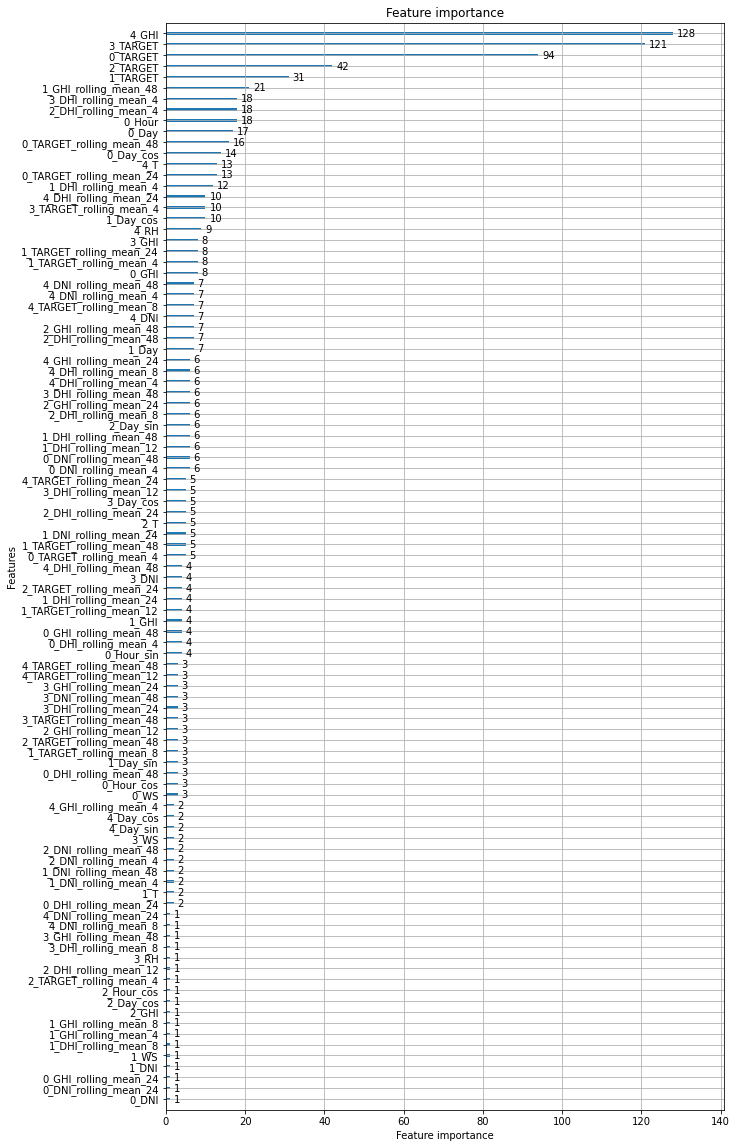

In [8]:
lgb.plot_importance(history[0][0.1]["bst_1"][0], figsize=(10, 20))

In [12]:
submission_df = load_submission_data()

result_list = history["submission_df"]
for result_df in result_list:
    for i in range(1, 10):
        q = i/10
        submission_df[f"q_{q}"] += result_df[f"q_{q}"]
                      
for i in range(1, 10):
    q = i/10
    submission_df[f"q_{q}"] = submission_df[f"q_{q}"] / index

In [13]:
submission_df[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.001516,0.014580,0.000064,0.000004
1,0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.001516,0.014580,0.000064,0.000004
2,0.csv_Day7_1h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.001516,0.014580,0.000064,0.000004
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.001516,0.014580,0.000064,0.000004
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.001516,0.014580,0.000064,0.000004
5,0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.001516,0.014580,0.000064,0.000004
6,0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.001516,0.014580,0.000064,0.000004
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.001516,0.014580,0.000064,0.000004
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.001516,0.014580,0.000064,0.000004
9,0.csv_Day7_4h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.001516,0.014580,0.000064,0.000004


In [11]:
submission_df.to_csv("lightgbm_gbdt_split_dataset_2021_01_14_1.csv", index=False)